# Projet final pour le cours M2MAS "Réseaux de Neurones profonds pour l'Apprentissage", année 2021-2022

Fichier ```NOM_Prenom_M2MAS_BloodMNIST_classification.ipynb``` à envoyer par email à `bruno.galerne@univ-orleans.fr` pour le lundi 7 mars 2022 (demande de délai supplémentaire possible si problème de dispo à cause de votre stage).

Envoi d'un lien à partir d'un cloud (partage renater, dropbox, google drive,...) si la taille du fichier est supérieur à 5 Mo.

# Classification of the BloodMNIST database


*Reference:*
 - [MedMNIST v2](https://medmnist.com/): A Large-Scale Lightweight Benchmark for 2D and 3D Biomedical Image Classification, Jiancheng Yang,Rui Shi,Donglai Wei,Zequan Liu,Lin Zhao,Bilian Ke,Hanspeter Pfister,Bingbing Ni, 2021.
Paper [arXiv](https://arxiv.org/pdf/2110.14795.pdf) Code [GitHub](https://github.com/MedMNIST/MedMNIST)



In [ ]:
!pip install medmnist

     |████████████████████████████████| 87 kB 3.7 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=49447241d233b9a7218c4f95e0c6cc09380a122f4220f10891b20029c84853ff
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


Import necessary libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import medmnist
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

MedMNIST v2.0.2 @ https://github.com/MedMNIST/MedMNIST/
cuda


Downlaod dataset and define dataloaders

In [ ]:
info = medmnist.INFO['bloodmnist']

for cell in info:
  print(cell)
  print(info[cell])
  print('\n')

python_class
BloodMNIST


description
The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.


url
https://zenodo.org/record/5208230/files/bloodmnist.npz?download=1


MD5
7053d0359d879ad8a5505303e11de1dc


task
multi-class


label
{'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'ig', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}


n_channels
3


n_samples
{'train': 11959, 'val': 1712, 'test': 3421}


license
CC BY 4.0




In [ ]:
BATCH_SIZE = 128

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
DataClass = getattr(medmnist, info['python_class'])
train_dataset = DataClass(split='train', transform=data_transform, download=True)
val_dataset = DataClass(split='val', transform=data_transform, download=True)
test_dataset = DataClass(split='test', transform=data_transform, download=True)

print(train_dataset)
print("===================")
print(test_dataset)
print("===================")
print(val_dataset)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

  0%|          | 0/35461855 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Dataset BloodMNIST (bloodmnist)
    Number of datapoints: 11959
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'ig', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3

Display function ```montage``` provided by MEDMNIST

In [ ]:
train_dataset.montage(1)

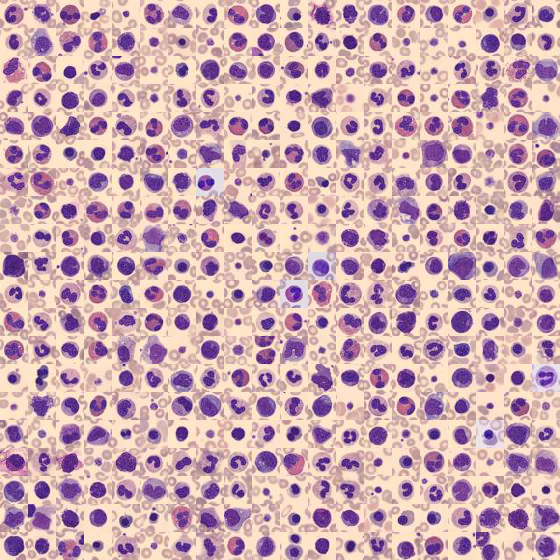

In [ ]:
train_dataset.montage(20)

Function to display a list of images (e.g. from a batch) :

Images:


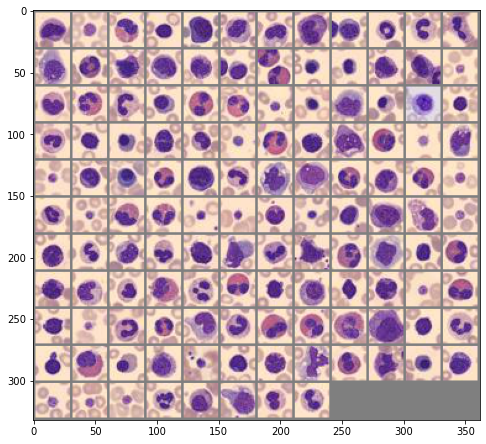

In [ ]:
def imshow(img):
    img = img.clone().detach().to('cpu')*0.5 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
print('Images:')
imshow(torchvision.utils.make_grid(images, nrow=12))

## Question 1: Answer the questions:

  1. What is the size of an image from the dataset ?

  2. How many images are in each split train/val/test ?

  3. What is the number of classes ?

### Answer:

1. Chaque image contenu dans notre dataset est de taille $3\times 28 \times 28$.

2. Les images contenues dans nos données sont réparties dans 3 datasets :
  - train dataset contenant 11959 images,
  -  val dataset formés par 1712 images
  - et enfin test dataset qui contient 3421 images.

3. Le nombre de class des images est de 8. Ces classes sont numérotées de 0 à 7 : **{0 : basophil, 1 : eosinophil, 2 : erythroblast, 3 : ig, 4 : lymphocyte, 5 : monocyte, 6 :  neutrophil, 7 :platelet}**


# A first neural network for classification:



We will classify the ```BloodMNIST```images using the following CNN architecture:
* CNN part:
  * A 2D convolution with 16 ouput chanels, followed by ReLU.
  * A 2D convolution with 16 ouput chanels, followed by ReLU.
  * A 2D max-pooling with size 2x2
  * A 2D convolution with 64 ouput chanels, followed by ReLU.
  * A 2D convolution with 64 ouput chanels, followed by ReLU.
  * A 2D convolution with 64 ouput chanels, followed by ReLU.
  * A 2D max-pooling with size 2x2
* Fully connected part:
  * A linear layer with output dimension 128, followed by ReLU.
  * A linear layer with output dimension 128, followed by ReLU.
  * A last linear layer



## Question 2:

For each step of the CNN, precise the size of the batch of the tensor starting from a tensor of size $b \times  c \times h \times w$ where $c \times h \times w$ are the answers of question 1.1.


### Answer:
Dans le forward(), en entrée, x est de taille **$128\times 3 \times 28 \times 28$** car la taille des batchs est de $b=128$.
- La première couche de convolution augmente la nombre de canaux et dimunie le nombre de pixels : x devient de taille **$128\times 16\times 26 \times 26$**. Les fonctions d'activation ``ReLU`` n'ont pas d'impact sur la taille des images.
- La deuxieme couche de convolution ne change pas le nombre de canaux des images mais change le nombre de pixels : x a alors une taille de  **$128\times 16 \times 24 \times 24$**.
- Avec la couche maxpool2D, la taille de x est  **$128\times 16 \times 12 \times 12$**.
- La troisième couche de convolution augmmente le nombre de canaux et renvoie x de taille **$128\times 64 \times 10 \times 10$**.
- La quatrieme couche de convolution n'augmmente pas le nombre de canaux et mais dimunie le nombre de pixels : x est de taille **$128\times 64 \times 8 \times 8$**.
- La cinquieme couche de convolution n'augmmente pas aussi le nombre de canaux et donne x  de taille **$128\times 64 \times 6 \times 6$**.
- La couche maxpool2D change le nombre de pixels. x devient de taille **$128\times 64 \times 3 \times 3$**.

Après les convolution et les MaxPooling, x est de taille $128\times 64×3×3$. Il faut d'abord applatir x en une matrice de taille $128\times576$ avec $576=64\times 3 \times 3$.
- La premiere couche linéaire donne une matrice de taille $128\times 128$.
- De même que la deuxieme couche linéaire donne une matrice de taille $128\times 128$.
- enfin, la dernière couche linéaire renvoie une matrice x de taille $128\times 8$.

## Question 3:

1. Define a class ```Net``` that implements in PyTorch the considered architecture for ```BloodMNIST``` classification.

2. Check that the forward function is well-defined by applying it to a batch of the training set.


On peut maintenant définir notre réseau de neurones Net().

In [ ]:
# TODO : Define class Net here
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1=nn.Conv2d(in_channels=3,out_channels=16,kernel_size=(3,3))
    self.conv2=nn.Conv2d(in_channels=16,out_channels=16,kernel_size=(3,3))
    self.maxp1=nn.MaxPool2d(kernel_size=(2,2))
    self.conv3=nn.Conv2d(in_channels=16,out_channels=64,kernel_size=(3,3))
    self.conv4=nn.Conv2d(in_channels=64,out_channels=64,kernel_size=(3,3))
    self.conv5=nn.Conv2d(in_channels=64,out_channels=64,kernel_size=(3,3))
    self.maxp2=nn.MaxPool2d(kernel_size=(2,2))
    self.fc1=nn.Linear(64*3*3,128)
    self.fc2=nn.Linear(128,128)
    self.fc3=nn.Linear(128,8)

  def forward(self,x):
    x=F.relu(self.conv1(x))
    x=F.relu(self.conv2(x))
    x=self.maxp1(x)
    x=F.relu(self.conv3(x))
    x=F.relu(self.conv4(x))
    x=F.relu(self.conv5(x))
    x=self.maxp2(x)
    x=x.view(-1,64*3*3)
    x=F.relu(self.fc1(x))
    x=F.relu(self.fc2(x))
    x=self.fc3(x)
    return(x)

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (maxp1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxp2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=8, bias=True)
)


On regarde si notre le modèle Net() est bien défini.

In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
output=net(images)
print(images.size())
print(output.size())

torch.Size([128, 3, 28, 28])
torch.Size([128, 8])


On peut dire que notre réseau de neurone est bien défini. Il prend en entrée un x de taille $128\times 3\times 28 \times 28$ et renvoie en sortie une matrice de taille $128\times 8$.

## Question 4:

The goal of this question is to train a neural network of your class ```model=Net()``` to classify the ```BloodMNIST``` dataset.

Propose a training script that:
 * has 6 epochs
 * uses the optimizer
    ```
    lr = 0.001
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    ```
 * at each epoch, computes the *epoch loss* (that is the mean of the training loss on each batch of the training set) and, and the end of each epoch, compute
the classification accuracy on the validation set.
 * print at the end of the training the time spent for training in minutes and seconds.
 * displays at the end of the training the two plots of running loss VS epochs and accuracy on validation set VS epochs.
 * displays at the end of the training a classification report and a confusion matrix on the validation set using scikit-learn.

**Entrainement du modèle**

Comme le réseau de neurones Net() est bien défini, on peut procéder à l'entrainement de ce modèle. A chaque époch, nous allons afficher la ``Loss`` et la précision sur les données de validation (``accuracy on validation set``).

In [ ]:
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 6
train_loss = []
val_accuaracy = []
since = time.time()
for epoch in range(num_epochs):  # loop over the dataset multiple times
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    model.train()
    running_loss = 0.0
    running_corrects = 0.0
    running_corrects1 = 0.0
    for images,labels in train_loader:
        # get the inputs; data is a list of [inputs, labels]
        labels = labels.view(-1)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()*images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_loss = np.append(train_loss,epoch_loss)

    with torch.no_grad():
      for images1,labels1 in val_loader:
        model.eval()
        labels1 = labels1.view(-1)
        outputs1 = model(images1)
        _, preds = torch.max(outputs1,1)
        running_corrects1 +=torch.sum(preds==labels1)
    val_acc = running_corrects1 / len(val_loader.dataset)
    val_accuaracy = np.append(val_accuaracy,val_acc)
    print(' running loss : {:.3}'.format(epoch_loss))
    print(' accuracy on validation set : {:.3}'.format(val_acc))
    print()
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

Epoch 0/5
----------
 running loss : 2.07
 accuracy on validation set : 0.182

Epoch 1/5
----------
 running loss : 2.05
 accuracy on validation set : 0.182

Epoch 2/5
----------
 running loss : 2.04
 accuracy on validation set : 0.195

Epoch 3/5
----------
 running loss : 2.03
 accuracy on validation set : 0.195

Epoch 4/5
----------
 running loss : 2.02
 accuracy on validation set : 0.195

Epoch 5/5
----------
 running loss : 2.02
 accuracy on validation set : 0.195

Training complete in 1m 42s


In [ ]:
cnn_to_train  = CNN()
loss_function = nn.MSELoss()
true_torch    = torch.from_numpy(true_np).float().unsqueeze(0).unsqueeze(0)
optimiser     = torch.optim.Adam(cnn_to_train.parameters(), lr=0.003)
loss          =  []
for epoch in range(550):
    output    = cnn_to_train(noisy_torch)
    loss      = loss_function(output, true_torch)
    #loss      = np.append(loss,0)
    loss.backward()      # computes dloss/dx for every parameter x
    optimiser.step()     # does the update
    optimiser.zero_grad()

    kernel_torch = list(cnn_to_train.parameters())[0]
    kernel_np    = np.squeeze(kernel_torch.detach().numpy())
    cnn_output   = np.squeeze(output.detach().numpy())
    print("PSNR :", PSNR(true_np, cnn_output))
    plt.imshow(cnn_output, cmap="gray")
    plt.show()

La durée d'entrainement du modèle pour 6 épochs est de **1m 42s** et on obtient une précision de **19.5%** sur les données de validation. C'est une mauvaise précision.

On peut tracer la ``loss`` en fonction des épochs et ``accuracy on validation set`` en fonction des épochs.

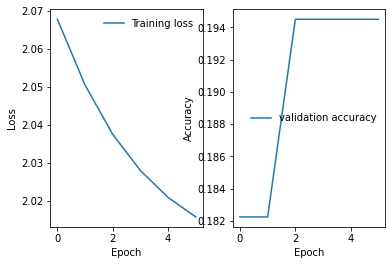

In [ ]:
plt.subplot(1,2,1)
plt.plot(train_loss,label="Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(frameon=False)

plt.subplot(1,2,2)
plt.plot(val_accuaracy,label="validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(frameon=False)
plt.show()

Enfin, on donne les performances du modèle sur les données de validation grâce avec `` classification report`` et ``confusion matrix``.

              precision    recall  f1-score   support

    basophil       0.00      0.00      0.00       122
  eosinophil       0.00      0.00      0.00       312
erythroblast       0.00      0.00      0.00       155
          ig       0.00      0.00      0.00       290
  lymphocyte       0.00      0.00      0.00       122
    monocyte       0.00      0.00      0.00       143
  neutrophil       0.19      1.00      0.33       333
    platelet       0.00      0.00      0.00       235

    accuracy                           0.19      1712
   macro avg       0.02      0.12      0.04      1712
weighted avg       0.04      0.19      0.06      1712



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


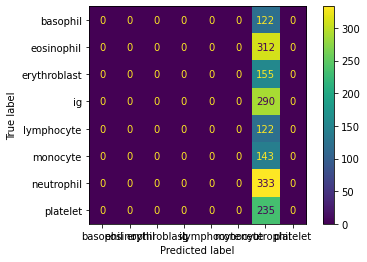

In [ ]:
class_names=['basophil','eosinophil','erythroblast','ig','lymphocyte','monocyte','neutrophil', 'platelet']
pred = []
true_labels = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
  for images,labels in val_loader:
    labels=labels.view(-1)
    # calculate outputs by running images through the network
    outputs = model(images)
    # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
    for j in range(images.size(0)):
      pred = np.append(pred,class_names[predicted[j]])
      true_labels = np.append(true_labels,class_names[labels[j]])

print(classification_report(true_labels,pred,labels=class_names))
cm=confusion_matrix(true_labels,pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()

La performance du modèle ``model`` sur les données de validation n'est pas bonne. On constate que notre modèle classe toutes les images comme étant dans la classe ``neutrophil``.

## Question 5:

Duplicate your training script below and adpat it so that the training is executed on the GPU.

Discuss before all the changes that needs to be done.

Report and discuss the difference of execution times.


### Answer:
Dans la question 4, l'entrainement du modèle s'est fait dans la ``cpu``. On va passer maintenant à la ``CPU`` pour faire l'entrainement. Il y a un certains nombre de changement à faire avec notre script précédent. Tout d'abord, il faut envoyer le modèle vers le ``GPU``, ce qui se fait grâce à ``model = model.to(device)``. Les images et les labels devront aussi être envoyés vers le ``CPU``: ``labels=labels.to(device), images = images.to(device)`` lors de l'entrainement mais aussi lors de l'évaluation du modèle. Pour pouvoir calculer la précision du modèle sur les données de validation, il faut recupérer les prédictions et les labels dans le ``cpu`` : `` preds = preds.to('cpu'), labels1 = labels1.to('cpu')``.

In [ ]:
model = Net()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 6
train_loss = []
val_accuracy = []
since = time.time()
for epoch in range(num_epochs):  # loop over the dataset multiple times
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    model.train()
    running_loss = 0.0
    running_corrects = 0.0
    running_corrects1 = 0.0
    for images,labels in train_loader:
        # get the inputs; data is a list of [inputs, labels]
        labels = labels.view(-1)
        labels=labels.to(device)
        images = images.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()*images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_loss = np.append(train_loss,epoch_loss)
    with torch.no_grad():
      for images1,labels1 in val_loader:
        model.eval()
        labels1 = labels1.view(-1)
        images1 = images1.to(device)
        labels1 = labels1.to(device)
        outputs1 = model(images1)
        _, preds = torch.max(outputs1,1)
        preds = preds.to('cpu')
        labels1 = labels1.to('cpu')
        running_corrects1 +=torch.sum(preds==labels1)
    val_acc = running_corrects1.double() / len(val_loader.dataset)
    val_accuracy = np.append(val_accuracy,val_acc)
    print(' running loss : {:.3}'.format(epoch_loss))
    print(' accuracy on validation set : {:.3}'.format(val_acc))
    print()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

Epoch 0/5
----------
 running loss : 2.07
 accuracy on validation set : 0.169

Epoch 1/5
----------
 running loss : 2.05
 accuracy on validation set : 0.169

Epoch 2/5
----------
 running loss : 2.04
 accuracy on validation set : 0.195

Epoch 3/5
----------
 running loss : 2.03
 accuracy on validation set : 0.195

Epoch 4/5
----------
 running loss : 2.02
 accuracy on validation set : 0.195

Epoch 5/5
----------
 running loss : 2.01
 accuracy on validation set : 0.195

Training complete in 0m 31s


### Answer:
Avec 6 épochs, lorsque l'entrainement s'était fait dans le ``cpu``, la durée était de **1m42s** alors que la durée de l'entrainement dans le ``GPU`` ne dure que **31s**. On voit que l'entrainement dans le ``GPU`` est beaucoup plus rapide que lorsqu'il est fait dans le ``cpu``. Cela est important car lorsque le nombre d'époch augmente, il est nécessaire d'avoir une durée d'entrainement moins longue.

## Question 6:

Re-execute a training on the GPU using 40 epochs (be careful to initialize a new network).

Discuss the performance of the final model.

On augmente maintenant le nombre d'épochs pour l'entrainement de notre modèle Net. L'entrainement se fait dans le ``GPU`` avec 40 épochs.

In [ ]:
model = Net()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 40
train_loss = []
val_accuracy = []
since = time.time()
for epoch in range(num_epochs):  # loop over the dataset multiple times
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    running_loss = 0.0
    running_corrects = 0.0

    model.train()
    for images,labels in train_loader:
        # get the inputs; data is a list of [inputs, labels]
        labels = labels.view(-1)
        labels=labels.to(device)
        images = images.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()*images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_loss = np.append(train_loss,running_loss)

    with torch.no_grad():
      for images1,labels1 in val_loader:
        model.eval()
        labels1 = labels1.view(-1)
        images1 = images1.to(device)
        labels1 = labels1.to(device)
        outputs1 = model(images1)
        _, preds = torch.max(outputs1,1)
        preds = preds.to('cpu')
        labels1 = labels1.to('cpu')
        running_corrects +=torch.sum(preds==labels1)
    val_acc = running_corrects.double() / len(val_loader.dataset)
    val_accuracy = np.append(val_accuracy,val_acc)

    print(' running loss : {:.3}'.format(epoch_loss))
    print(' accuracy on validation set : {:.3}'.format(val_acc))
    print()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

Epoch 0/39
----------
 running loss : 2.07
 accuracy on validation set : 0.195

Epoch 1/39
----------
 running loss : 2.05
 accuracy on validation set : 0.195

Epoch 2/39
----------
 running loss : 2.04
 accuracy on validation set : 0.195

Epoch 3/39
----------
 running loss : 2.03
 accuracy on validation set : 0.195

Epoch 4/39
----------
 running loss : 2.02
 accuracy on validation set : 0.195

Epoch 5/39
----------
 running loss : 2.02
 accuracy on validation set : 0.195

Epoch 6/39
----------
 running loss : 2.01
 accuracy on validation set : 0.195

Epoch 7/39
----------
 running loss : 2.01
 accuracy on validation set : 0.195

Epoch 8/39
----------
 running loss : 2.01
 accuracy on validation set : 0.195

Epoch 9/39
----------
 running loss : 2.01
 accuracy on validation set : 0.195

Epoch 10/39
----------
 running loss : 2.0
 accuracy on validation set : 0.195

Epoch 11/39
----------
 running loss : 2.0
 accuracy on validation set : 0.195

Epoch 12/39
----------
 running loss : 2

En augmentant le nombre d'épochs, on obtient une meilleure précision du modèle.
On constate que pour 40 épochs, l'entrainement du modèle à duré **3m 26s** et on obtient une précision de **74.3%** sur les données de validation. Nous constatons aussi que la précision du modèle sur les données de validation reste constante sur les premiers épochs.



**Performance finale du modèle**

Pour tester la performance finale du modèle, on utilise les données de test.

              precision    recall  f1-score   support

    basophil       0.42      0.64      0.51       244
  eosinophil       0.80      0.87      0.84       624
erythroblast       0.80      0.71      0.75       311
          ig       0.54      0.68      0.60       579
  lymphocyte       0.76      0.65      0.70       243
    monocyte       0.50      0.19      0.28       284
  neutrophil       0.92      0.81      0.86       666
    platelet       0.96      0.94      0.95       470

    accuracy                           0.73      3421
   macro avg       0.71      0.69      0.69      3421
weighted avg       0.75      0.73      0.73      3421



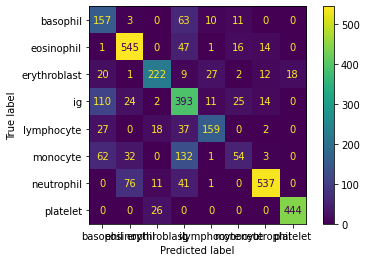

In [ ]:

class_names=['basophil','eosinophil','erythroblast','ig','lymphocyte','monocyte','neutrophil', 'platelet']
pred = []
true_labels = []
ntest=0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
  for images,labels in test_loader:
    labels=labels.view(-1)
    images = images.to(device)
    labels = labels.to(device)
      # calculate outputs by running images through the network
    outputs = model(images)
      # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
    predicted1 = predicted.to('cpu')
    labels1 = labels.to('cpu')

    for j in range(len(predicted1)):
      pred = np.append(pred,class_names[predicted1[j]])
      true_labels = np.append(true_labels,class_names[labels1[j]])

print(classification_report(true_labels,pred,labels=class_names))
cm=confusion_matrix(true_labels,pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
disp.plot()

### Answer:
Pour un nombre d'épochs égale à 40, on obtient une précision de **71%** sur les données de test. Le modèle devient plus précis même s'il a du mal à classer les images des classes suivantes : `` basophil, ig, monocyte``. Il est beaucoup plus précis pour la classe ``platelet``.

# A second neural network for classification:



## Question 7:

We will now try to improve the architecture by introducing batch normalization layers within the network.

1. Define a new class ```Net_with_BN``` that adds a 2D batchnormalization layer between each 2D-convolution layer and ReLU activation layer (that is after the 2D convolution and before ReLU).

2. Train a model ```model_with_bn = Net_with_BN()``` (on the GPU with 40 epochs) and produce the usual report.
Hint: do not forget to use
```
model_with_bn.train()  # before training
model_with_bn.eval()   # before prediction
```

3. Are the performances similar ? What is the interest of using batchnormalization layers ?



**Definissons le model_with_bn**

Nous définissons un modèle en se basant sur le modèle Net() où l'on ajoute une ``BatchNormalization`` après chaque couche de convolution et avant les fonctions d'activation ``ReLU``.

In [ ]:
# TODO: Define class Net_with_BN:
class Net_with_BN(nn.Module):
  def __init__(self):
    super(Net_with_BN, self).__init__()
    self.conv1=nn.Conv2d(in_channels=3,out_channels=16,kernel_size=(3,3))
    self.norm1=nn.BatchNorm2d(16)
    self.conv2=nn.Conv2d(in_channels=16,out_channels=16,kernel_size=(3,3))
    self.norm2=nn.BatchNorm2d(16)
    self.maxp1=nn.MaxPool2d(kernel_size=(2,2))
    self.conv3=nn.Conv2d(in_channels=16,out_channels=64,kernel_size=(3,3))
    self.norm3=nn.BatchNorm2d(64)
    self.conv4=nn.Conv2d(in_channels=64,out_channels=64,kernel_size=(3,3))
    self.norm4=nn.BatchNorm2d(64)
    self.conv5=nn.Conv2d(in_channels=64,out_channels=64,kernel_size=(3,3))
    self.norm5=nn.BatchNorm2d(64)
    self.maxp2=nn.MaxPool2d(kernel_size=(2,2))
    self.fc1=nn.Linear(64*3*3,128)
    self.fc2=nn.Linear(128,128)
    self.fc3=nn.Linear(128,8)

  def forward(self,x):
    x=self.conv1(x)
    x=F.relu(self.norm1(x))
    x=self.conv2(x)
    x=F.relu(self.norm2(x))
    x=self.maxp1(x)
    x=self.conv3(x)
    x=F.relu(self.norm3(x))
    x=self.conv4(x)
    x=F.relu(self.norm4(x))
    x=self.conv5(x)
    x=F.relu(self.norm5(x))
    x=self.maxp2(x)
    x=x.view(-1,64*3*3)
    x=F.relu(self.fc1(x))
    x=F.relu(self.fc2(x))
    x=self.fc3(x)
    return(x)

model_with_bn = Net_with_BN()

**Entrainement du modèle model_with_bn**

On passe maintenant à l'entrainement du modèle et on affiche la loss et la précision sur les données de validation à chaque epoch.

In [ ]:
model_with_bn = Net_with_BN()
model_with_bn = model_with_bn.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_with_bn.parameters(), lr=0.001, momentum=0.9)
num_epochs = 40
train_loss = []
val_accuracy = []
since = time.time()
for epoch in range(num_epochs):  # loop over the dataset multiple times
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    model_with_bn.train()
    running_loss = 0.0
    running_corrects = 0.0
    running_corrects1 = 0.0
    for images,labels in train_loader:
        # get the inputs; data is a list of [inputs, labels]
        labels = labels.view(-1)
        labels=labels.to(device)
        images = images.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model_with_bn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()*images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_loss = np.append(train_loss,epoch_loss)

    with torch.no_grad():
      for images1,labels1 in val_loader:
        model_with_bn.eval()
        labels1 = labels1.view(-1)
        images1 = images1.to(device)
        labels1 = labels1.to(device)
        outputs1 = model_with_bn(images1)
        _, preds = torch.max(outputs1,1)
        preds = preds.to('cpu')
        labels1 = labels1.to('cpu')
        running_corrects1 +=torch.sum(preds==labels1)
    val_acc = running_corrects1.double() / len(val_loader.dataset)
    val_accuracy = np.append(val_accuracy,val_acc)

    print(' running loss : {:.3}'.format(epoch_loss))
    print(' accuracy on validation set : {:.3}'.format(val_acc))
    print()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

Epoch 0/39
----------
 running loss : 1.84
 accuracy on validation set : 0.536

Epoch 1/39
----------
 running loss : 1.17
 accuracy on validation set : 0.729

Epoch 2/39
----------
 running loss : 0.74
 accuracy on validation set : 0.774

Epoch 3/39
----------
 running loss : 0.56
 accuracy on validation set : 0.831

Epoch 4/39
----------
 running loss : 0.455
 accuracy on validation set : 0.833

Epoch 5/39
----------
 running loss : 0.396
 accuracy on validation set : 0.846

Epoch 6/39
----------
 running loss : 0.35
 accuracy on validation set : 0.87

Epoch 7/39
----------
 running loss : 0.311
 accuracy on validation set : 0.888

Epoch 8/39
----------
 running loss : 0.282
 accuracy on validation set : 0.884

Epoch 9/39
----------
 running loss : 0.251
 accuracy on validation set : 0.902

Epoch 10/39
----------
 running loss : 0.223
 accuracy on validation set : 0.899

Epoch 11/39
----------
 running loss : 0.207
 accuracy on validation set : 0.889

Epoch 12/39
----------
 running 

Pour 40 épochs, on otient une précision de **93.9%** sur les données de validation avec notre nouveau modèle ``model_with_bn``. C'est une très bonne précision. Comme l'entrainement s'est fait dans le ``GPU``, il a duré **3m 37s**.

Nous pouvons aussi tracer la loss en fonction des epochs et la précision sur les données de validation en fonction des epochs.

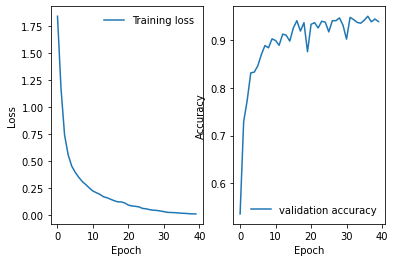

In [ ]:
plt.subplot(1,2,1)
plt.plot(train_loss,label="Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(frameon=False)
plt.subplot(1,2,2)
plt.plot(val_accuracy,label="validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(frameon=False)
plt.show()

**Performance du modèle model_with_bn**

Pour avoir une idée sur la performance du modèle ``model_with bn``, on utilise les données de test. Nous donnons la ``classification_report`` et la matrice de confusion.

              precision    recall  f1-score   support

    basophil       0.89      0.90      0.89       244
  eosinophil       0.96      0.99      0.98       624
erythroblast       0.97      0.92      0.95       311
          ig       0.90      0.83      0.87       579
  lymphocyte       0.96      0.88      0.92       243
    monocyte       0.80      0.93      0.86       284
  neutrophil       0.96      0.97      0.96       666
    platelet       0.99      1.00      0.99       470

    accuracy                           0.94      3421
   macro avg       0.93      0.93      0.93      3421
weighted avg       0.94      0.94      0.94      3421



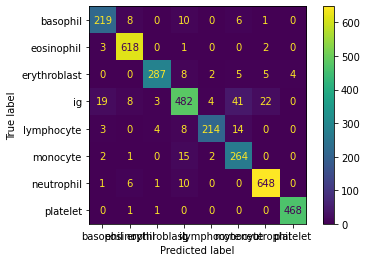

In [ ]:
class_names=['basophil','eosinophil','erythroblast','ig','lymphocyte','monocyte','neutrophil', 'platelet']
pred = []
true_labels = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
  for images,labels in test_loader:
    labels=labels.view(-1)
    images = images.to(device)
    labels = labels.to(device)
      # calculate outputs by running images through the network
    outputs = model_with_bn(images)
      # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
    predicted1 = predicted.to('cpu')
    labels1 = labels.to('cpu')
    for j in range(len(predicted1)):
      pred = np.append(pred,class_names[predicted1[j]])
      true_labels = np.append(true_labels,class_names[labels1[j]])

  print(classification_report(true_labels,pred,labels=class_names))
  cm=confusion_matrix(true_labels,pred)
  disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
  disp.plot()

### Answer:

Avec le modèle ``model_with_bn``, on otient une précision de **93%** sur les données de test. On obtient un meilleur classifieur pour nos images. Rappelons que la précision du modèle ``model`` sur nos données de test est de **71%**. Donc l'ajout des ``BatchNormalization`` a eu un impact positif sur la précision du modèle. Il a permis de faciliter l'entrainement du modèle et ce dernier apprend beaucoup plus vite. On obtient une meilleure précision avec la BatchNormalization. Dans l'entrainement du modèle ``model``, on pouvait observer que la precision ne changait pas sur beaucoup d'épochs successifs. La BatchNormalization a permis de régler ce problème.



## Question 8:
What is the proper way to determine which model is the best between the trained ```model``` from class ```Net()``` and the trained ```model_with_bn``` from class ```model_with_bn = Net_with_BN()``` ?

Propose a script to answer this question.

### Answer:
Pour choisir le meilleur modèle entre ``model`` entrainé et ``model_with_bn`` entrainé, on regarde celui qui a la meilleure précision sur les données de validation sur les différents épochs.

Pour ce faire, on entraine les deux modèles sur 40 épochs et à chaque fois, on regarde la précision sur les données de validation. On retient le meilleur comme le modèle ayant la plus grande précision sur les données de validation.

In [ ]:
import copy

In [ ]:
# Code: Script for best model
model1 = Net()
model1 = model1.to(device)
model2 = Net_with_BN()
model2 = model2.to(device)

criterion = nn.CrossEntropyLoss()
num_epochs = 40
since = time.time()
best_acc = 0.0

for model in [model1,model2]:
  best_model_wts = copy.deepcopy(model.state_dict())
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  for epoch in range(num_epochs):  # loop over the dataset multiple times
      print('Epoch {}/{}'.format(epoch, num_epochs - 1))
      print('-' * 10)
      model.train()
      running_loss = 0.0
      running_corrects = 0.0
      running_corrects1 = 0.0
      for images,labels in train_loader:
          # get the inputs; data is a list of [inputs, labels]
          labels = labels.view(-1)
          labels=labels.to(device)
          images = images.to(device)
          # zero the parameter gradients
          optimizer.zero_grad()
          # forward + backward + optimize
          outputs = model(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          # print statistics
          running_loss += loss.item()*images.size(0)
      epoch_loss = running_loss / len(train_loader.dataset)

      with torch.no_grad():
        for images1,labels1 in val_loader:
          model.eval()
          labels1 = labels1.view(-1)
          images1 = images1.to(device)
          labels1 = labels1.to(device)
          outputs1 = model(images1)
          _, preds = torch.max(outputs1,1)
          preds = preds.to('cpu')
          labels1 = labels1.to('cpu')
          running_corrects1 +=torch.sum(preds==labels1)
      epoch_acc = running_corrects1.double() / len(val_loader.dataset)

      if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

      print(' loss : {:.3}'.format(epoch_loss))
      print(' acc : {:.3}'.format(epoch_acc))
      print()

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))

# load best model weights
model.load_state_dict(best_model_wts)

Epoch 0/39
----------
 loss : 2.07
 acc : 0.182

Epoch 1/39
----------
 loss : 2.05
 acc : 0.182

Epoch 2/39
----------
 loss : 2.04
 acc : 0.204

Epoch 3/39
----------
 loss : 2.03
 acc : 0.195

Epoch 4/39
----------
 loss : 2.02
 acc : 0.195

Epoch 5/39
----------
 loss : 2.02
 acc : 0.195

Epoch 6/39
----------
 loss : 2.01
 acc : 0.195

Epoch 7/39
----------
 loss : 2.01
 acc : 0.195

Epoch 8/39
----------
 loss : 2.01
 acc : 0.195

Epoch 9/39
----------
 loss : 2.0
 acc : 0.195

Epoch 10/39
----------
 loss : 2.0
 acc : 0.195

Epoch 11/39
----------
 loss : 2.0
 acc : 0.195

Epoch 12/39
----------
 loss : 2.0
 acc : 0.195

Epoch 13/39
----------
 loss : 2.0
 acc : 0.195

Epoch 14/39
----------
 loss : 2.0
 acc : 0.195

Epoch 15/39
----------
 loss : 2.0
 acc : 0.195

Epoch 16/39
----------
 loss : 2.0
 acc : 0.195

Epoch 17/39
----------
 loss : 1.99
 acc : 0.195

Epoch 18/39
----------
 loss : 1.99
 acc : 0.195

Epoch 19/39
----------
 loss : 1.96
 acc : 0.327

Epoch 20/39
------

<All keys matched successfully>

### Answer:

Le milleur modèle à une précision de **95%** sur les données de validation. C'est une très bonne précision. Donc on peut s'attendre à ce qu'il est une bonne précision sur les données de test aussi.

On regarde la performance du meilleur modèle sur les données de test.

              precision    recall  f1-score   support

    basophil       0.94      0.89      0.91       244
  eosinophil       0.99      0.99      0.99       624
erythroblast       0.97      0.94      0.95       311
          ig       0.82      0.91      0.86       579
  lymphocyte       0.95      0.92      0.94       243
    monocyte       0.88      0.81      0.84       284
  neutrophil       0.97      0.96      0.96       666
    platelet       1.00      1.00      1.00       470

    accuracy                           0.94      3421
   macro avg       0.94      0.93      0.93      3421
weighted avg       0.94      0.94      0.94      3421



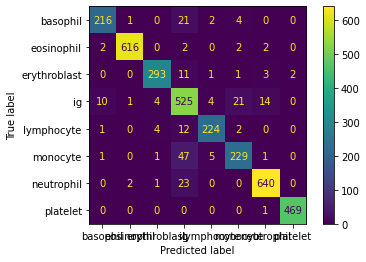

In [ ]:
class_names=['basophil','eosinophil','erythroblast','ig','lymphocyte','monocyte','neutrophil', 'platelet']
pred = []
true_labels = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
  for images,labels in test_loader:
    labels=labels.view(-1)
    images = images.to(device)
    labels = labels.to(device)
      # calculate outputs by running images through the network
    outputs = model(images)
      # the class with the highest energy is what we choose as prediction
    _, predicted = torch.max(outputs.data, 1)
    predicted1 = predicted.to('cpu')
    labels1 = labels.to('cpu')
    for j in range(images.size()[0]):
      pred = np.append(pred,class_names[predicted1[j]])
      true_labels = np.append(true_labels,class_names[labels1[j]])

  print(classification_report(true_labels,pred,labels=class_names))
  cm=confusion_matrix(true_labels,pred)
  disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
  disp.plot()

On remarque que le meilleur modèle obtenu a une précision de **94%** sur les données de test et est très pécis en terme de prédiction.

On peut maintenant regarder certaines images avec leurs labels prédicts par notre meilleur modèle.

In [ ]:
def visualize_model(model):
    images_so_far = 0
    fig = plt.figure()

    dataiter=iter(val_loader)
    inputs, labels = dataiter.next()
    inputs = inputs.to(device)
    labels = labels.to(device)
    imshow(torchvision.utils.make_grid(inputs, nrow=12))
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    num_images = inputs.size()[0]
    for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('predicted: {}'.format(class_names[preds[j]]))
        imshow(torchvision.utils.make_grid(images[j,:,:,:], nrow=1))

<Figure size 432x288 with 0 Axes>

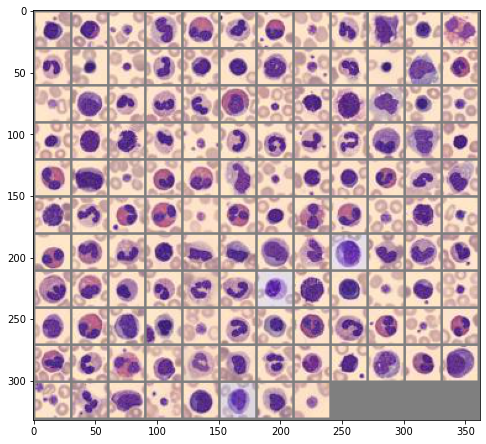

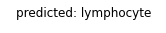

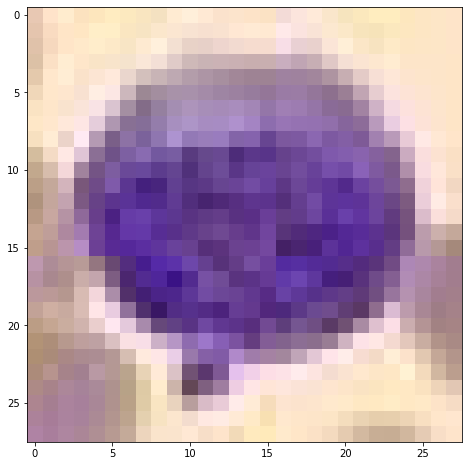

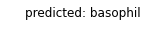

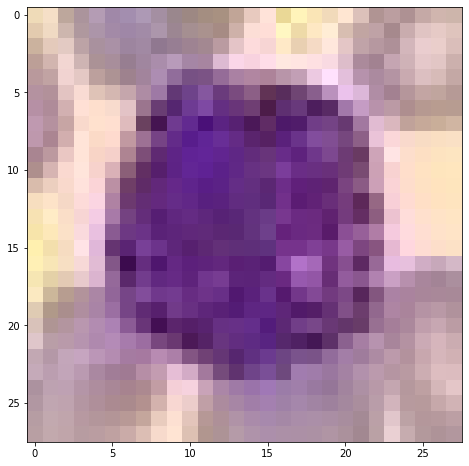

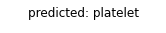

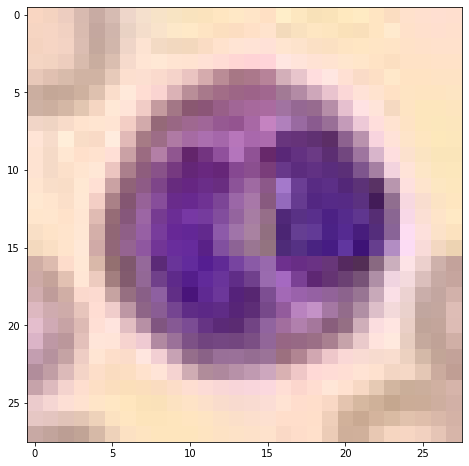

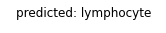

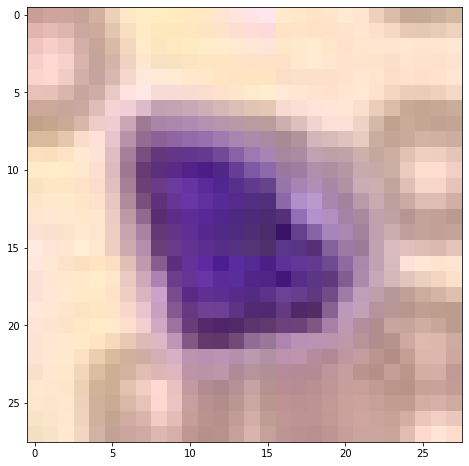

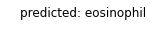

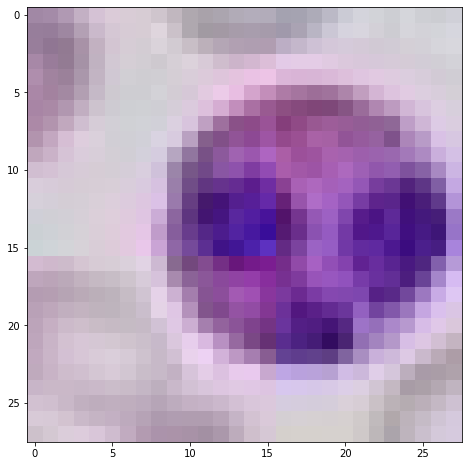

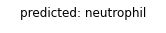

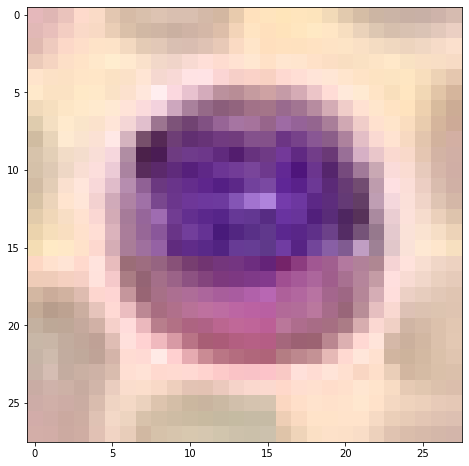

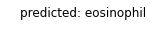

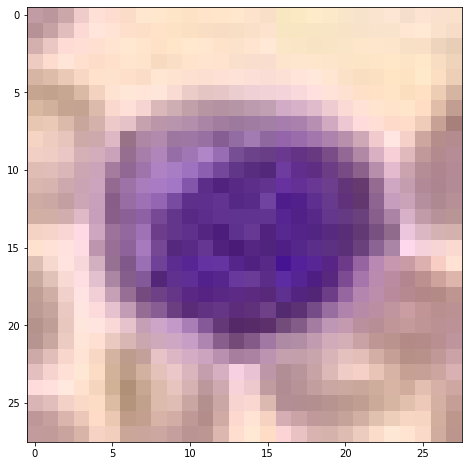

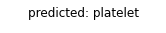

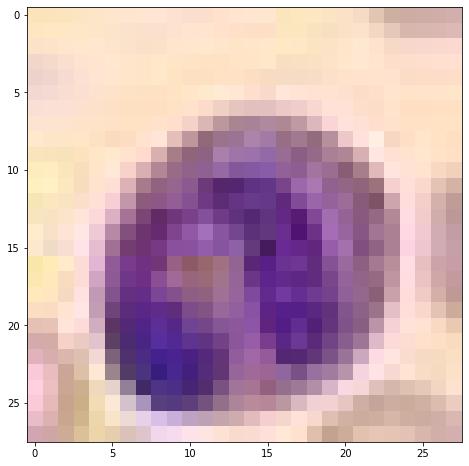

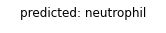

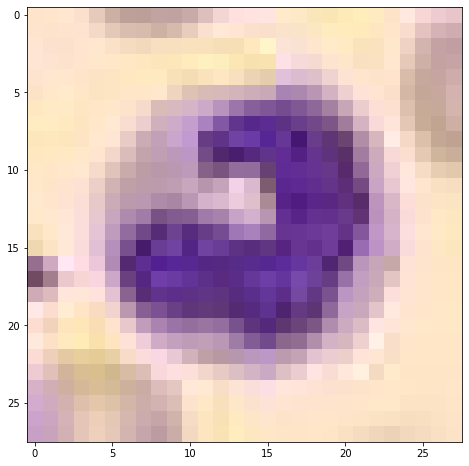

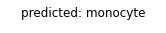

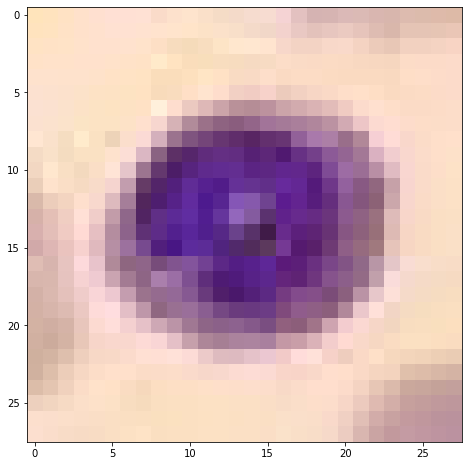

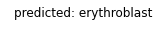

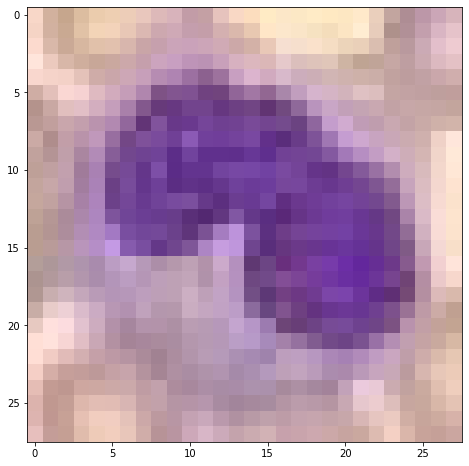

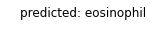

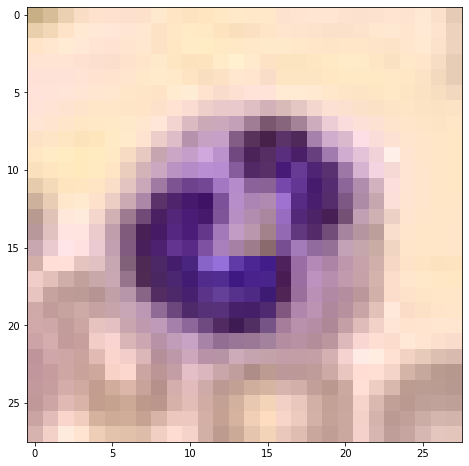

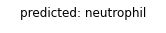

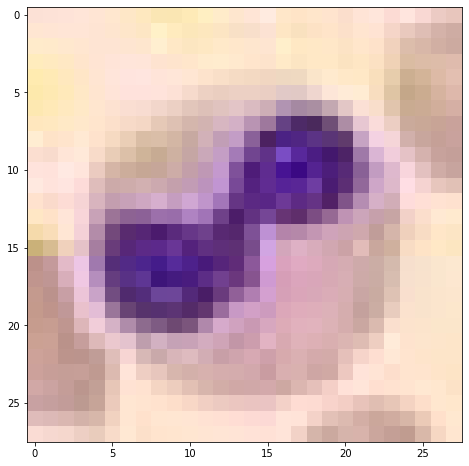

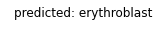

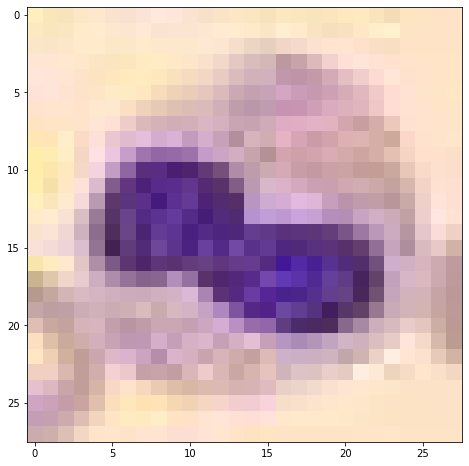

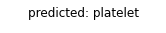

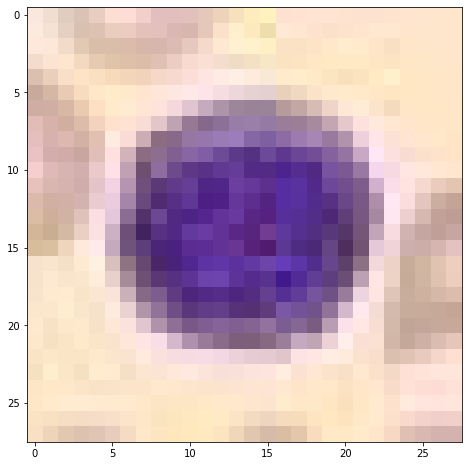

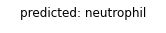

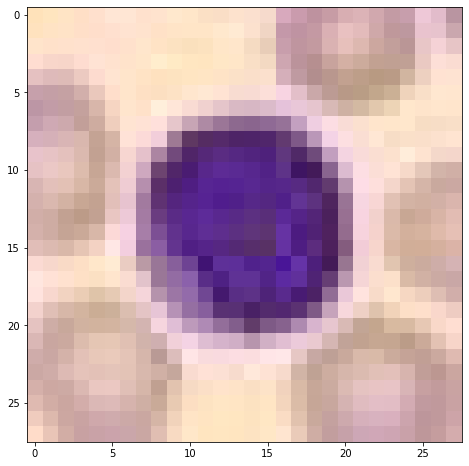

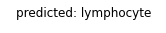

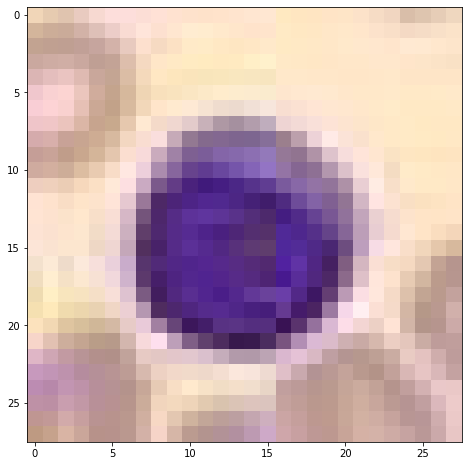

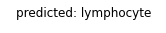

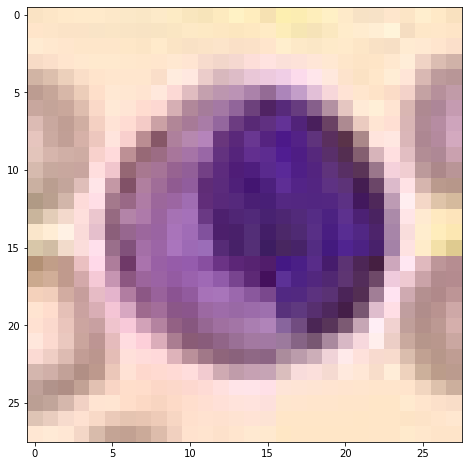

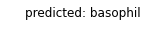

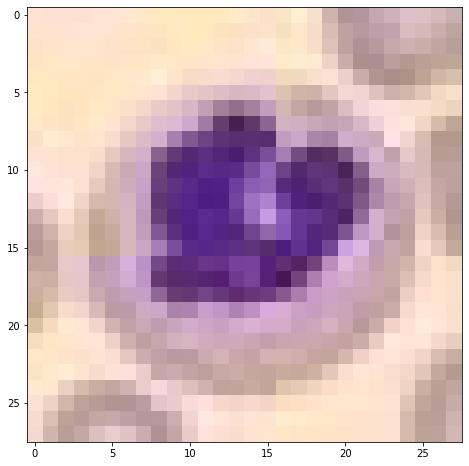

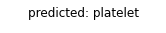

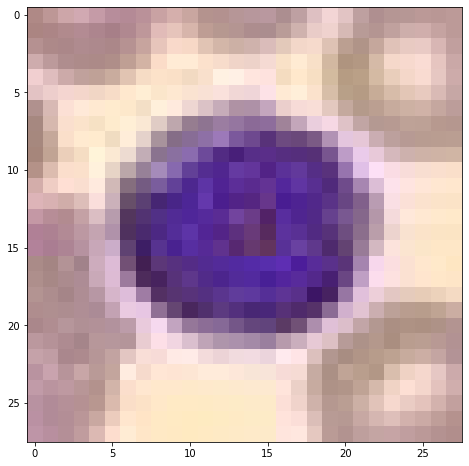

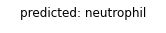

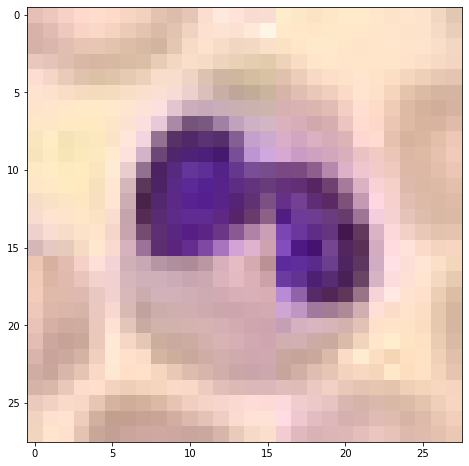

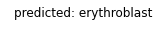

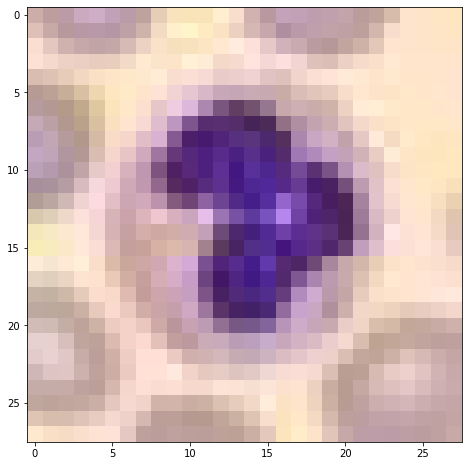

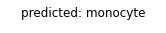

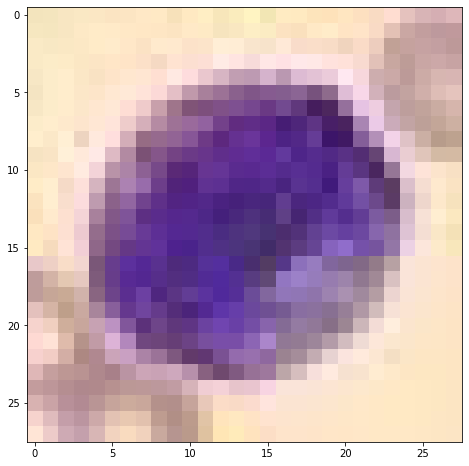

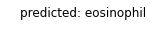

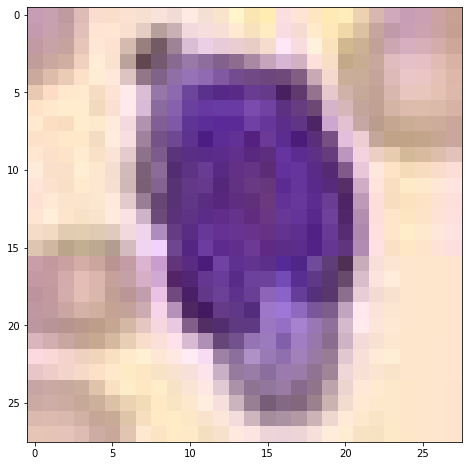

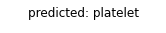

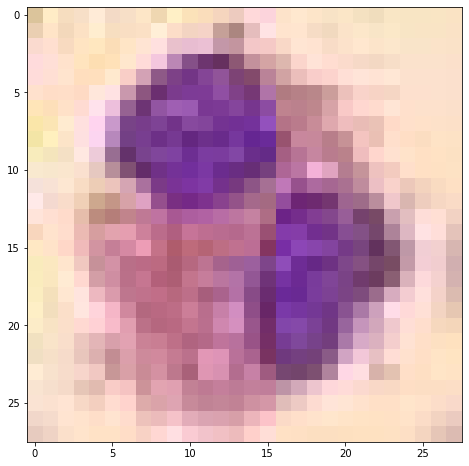

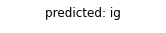

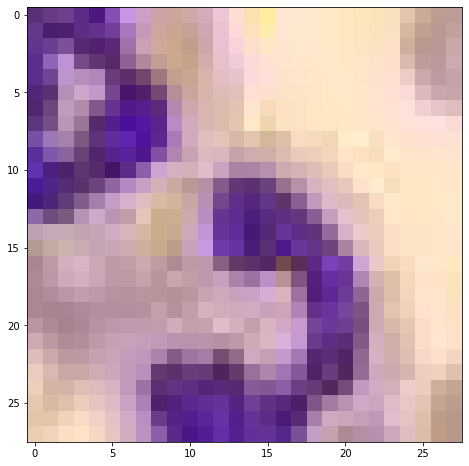

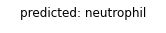

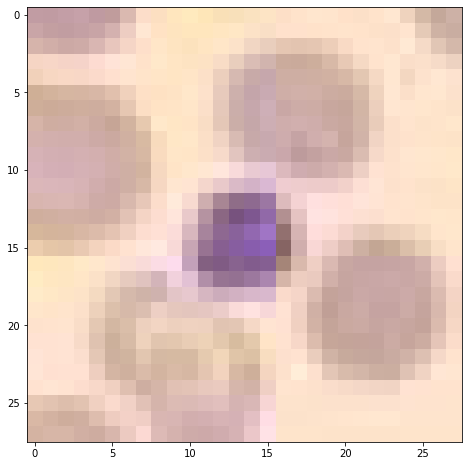

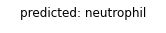

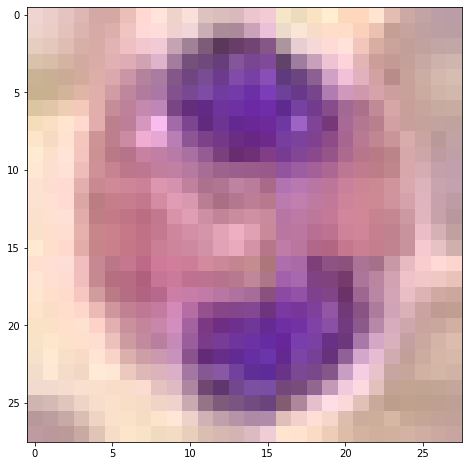

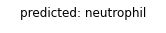

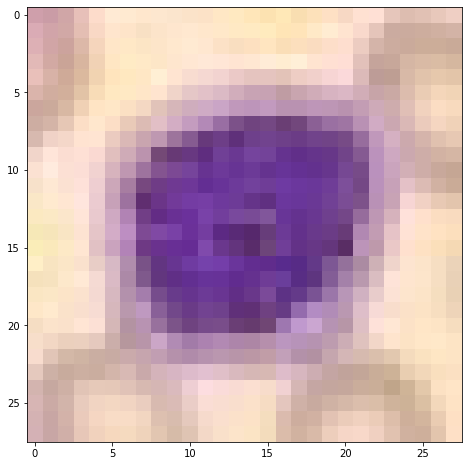

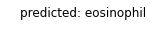

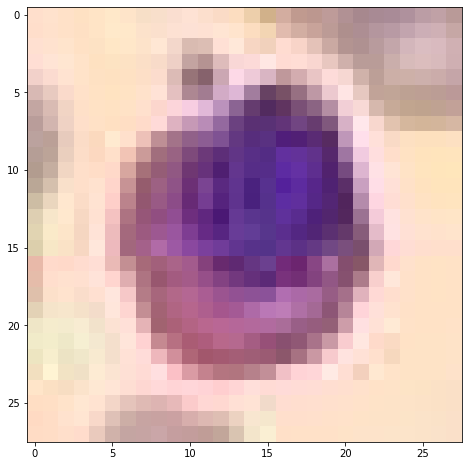

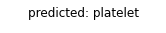

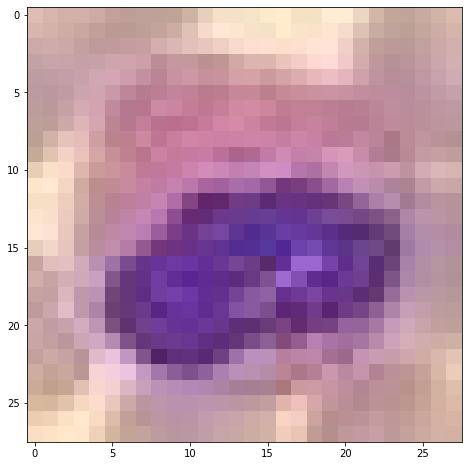

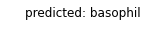

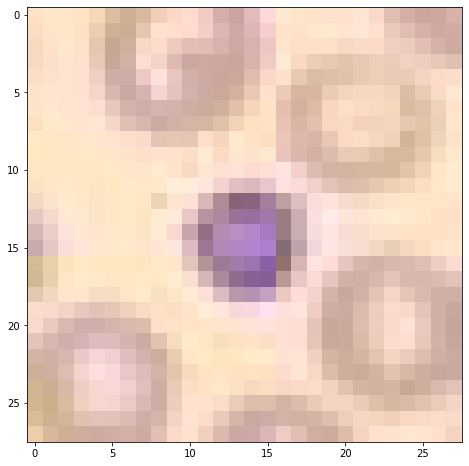

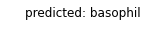

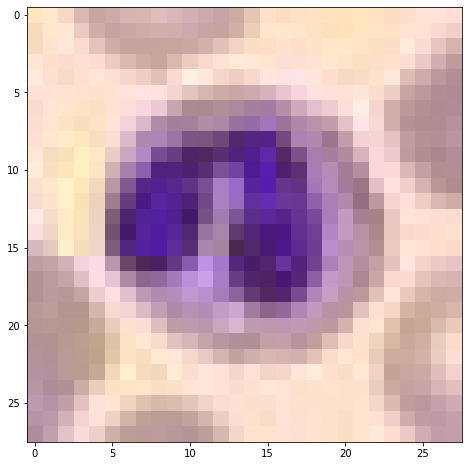

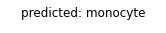

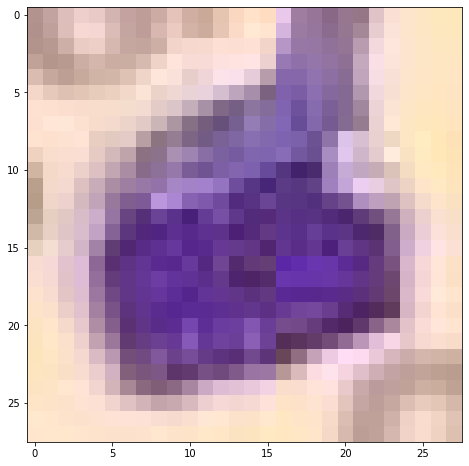

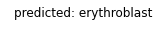

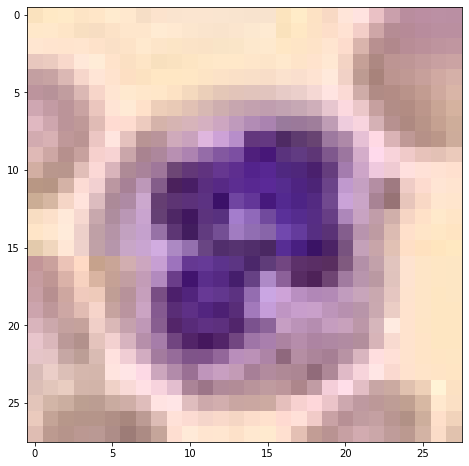

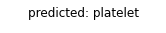

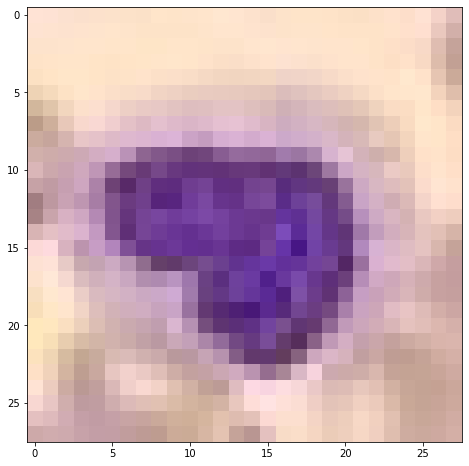

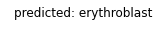

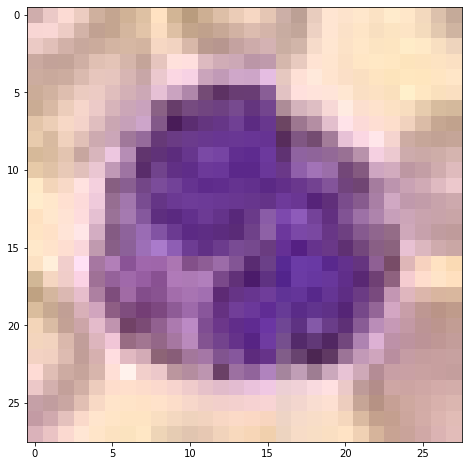

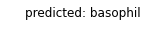

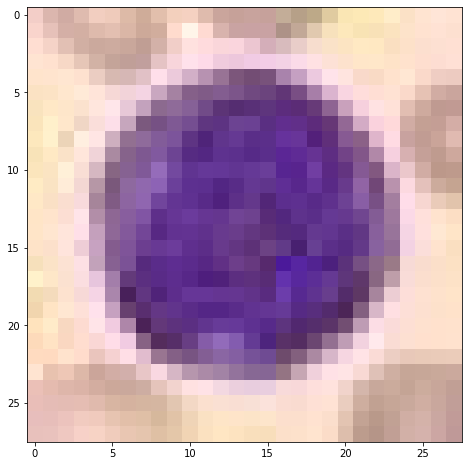

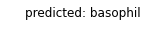

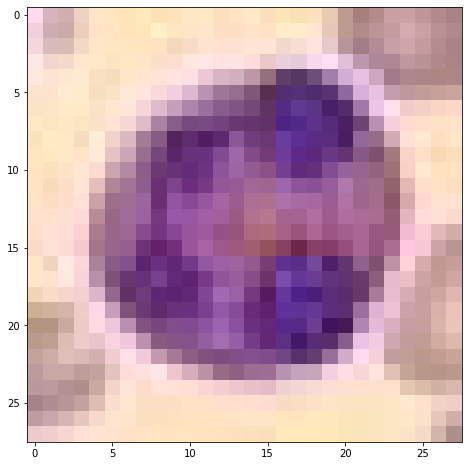

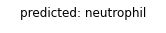

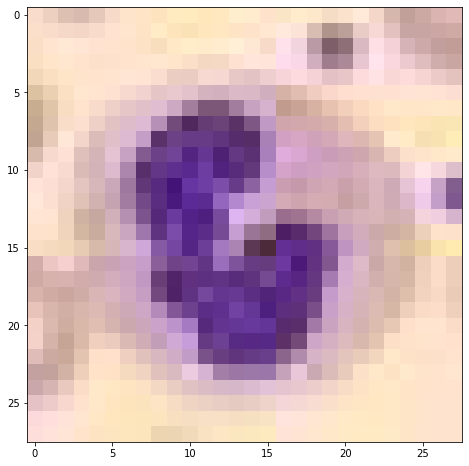

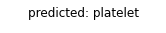

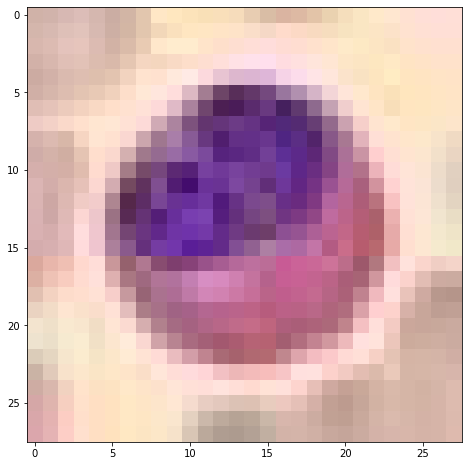

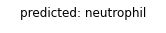

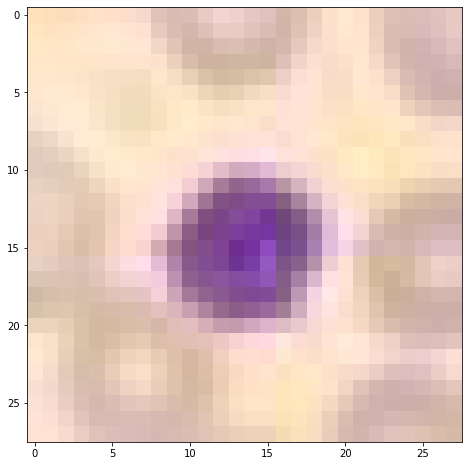

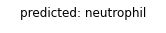

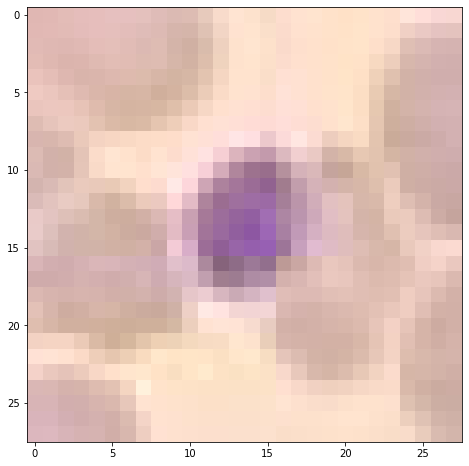

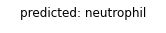

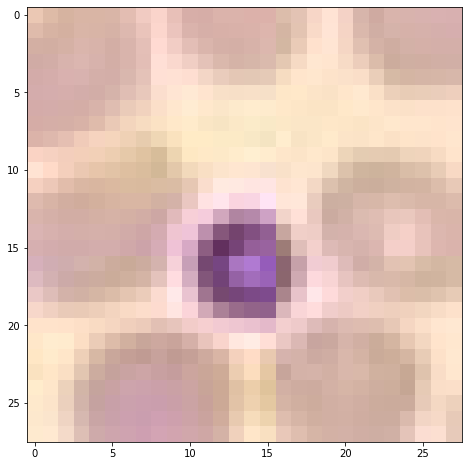

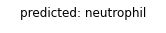

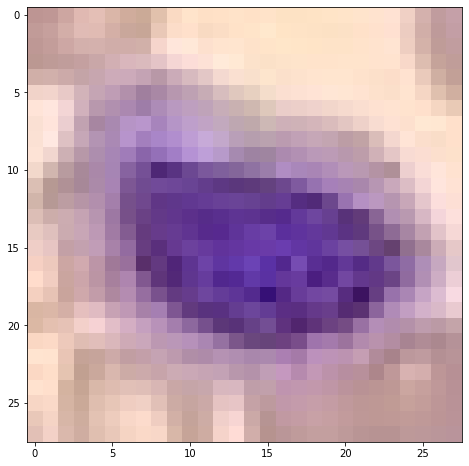

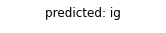

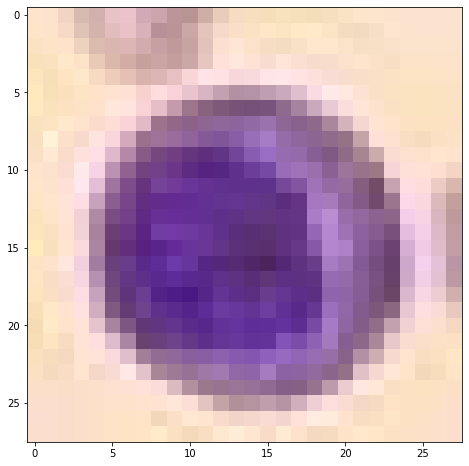

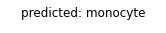

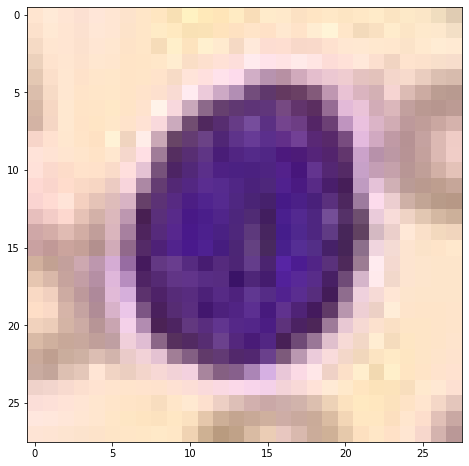

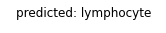

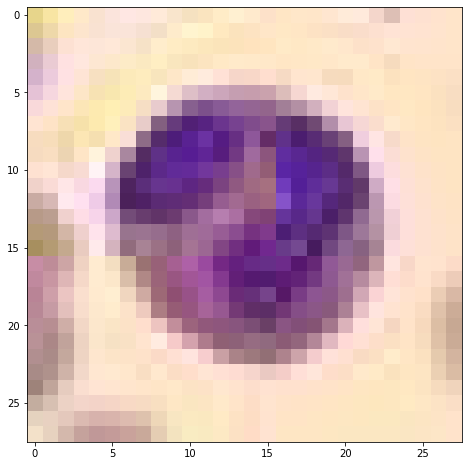

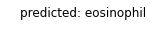

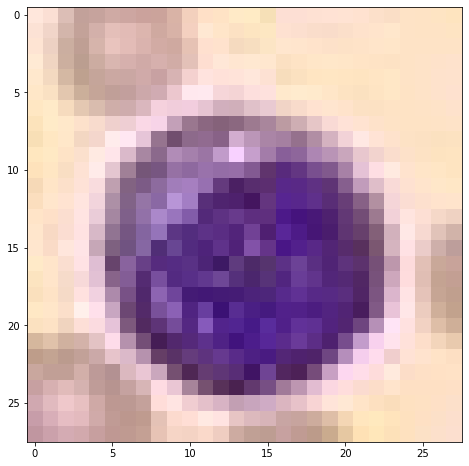

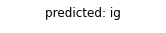

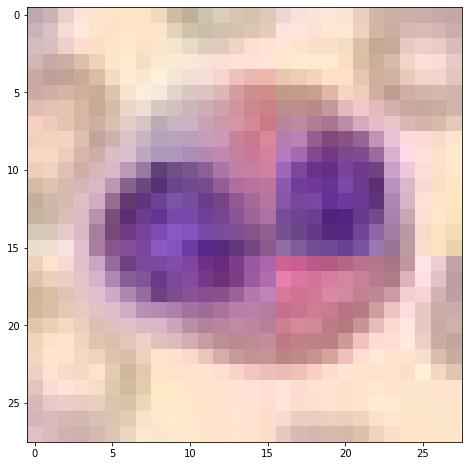

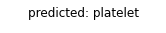

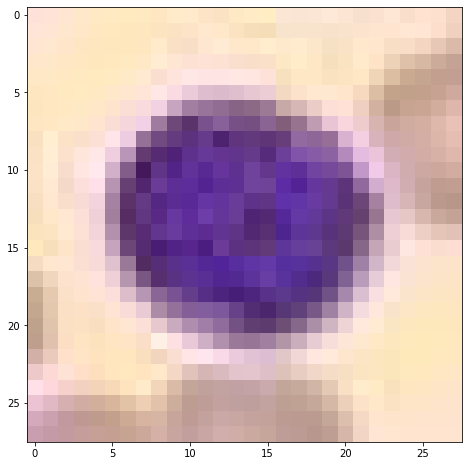

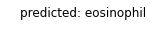

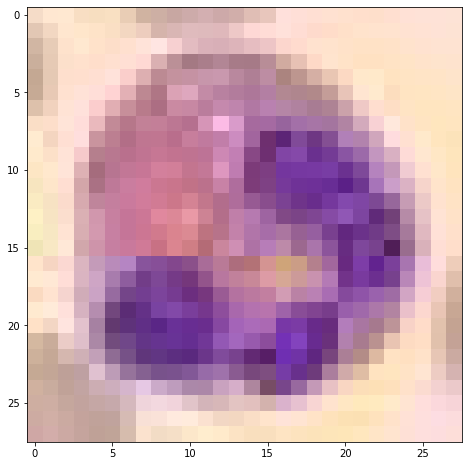

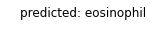

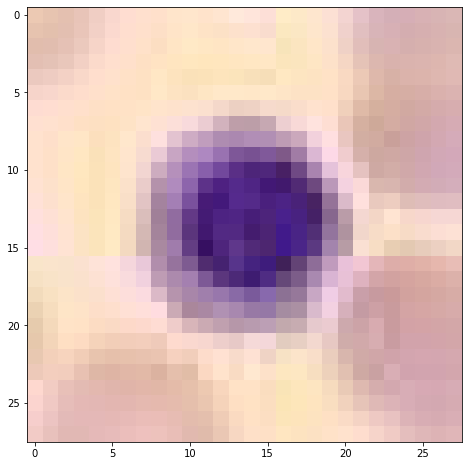

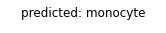

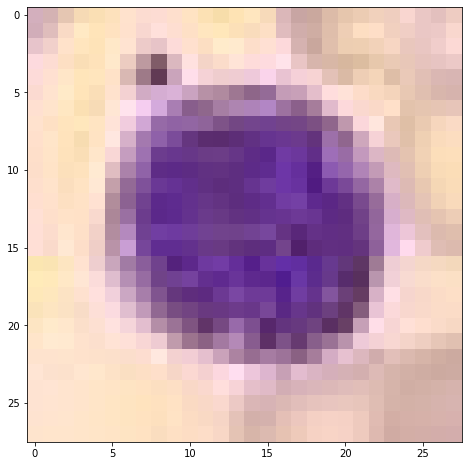

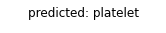

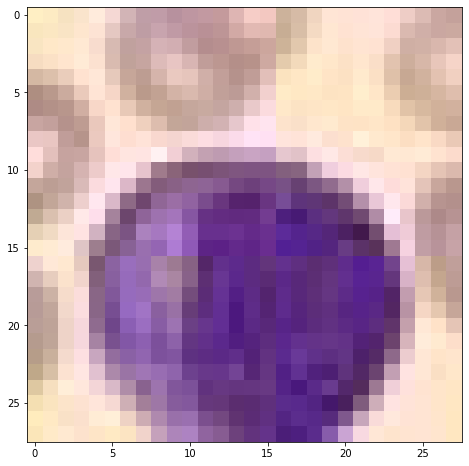

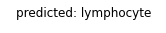

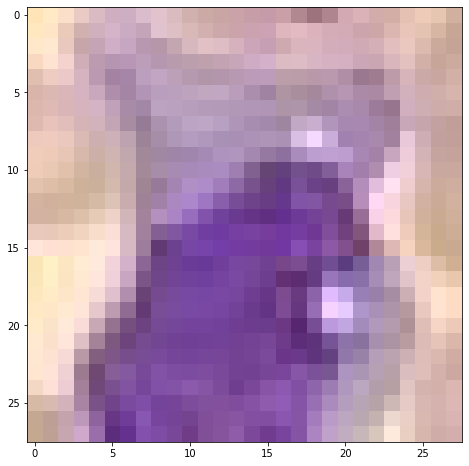

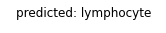

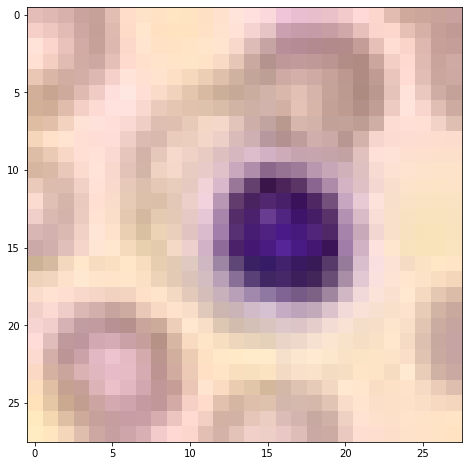

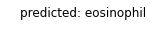

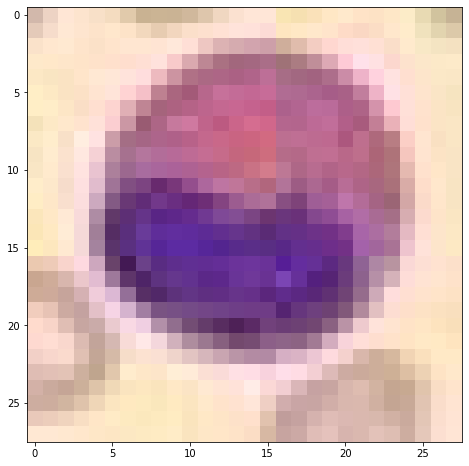

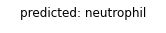

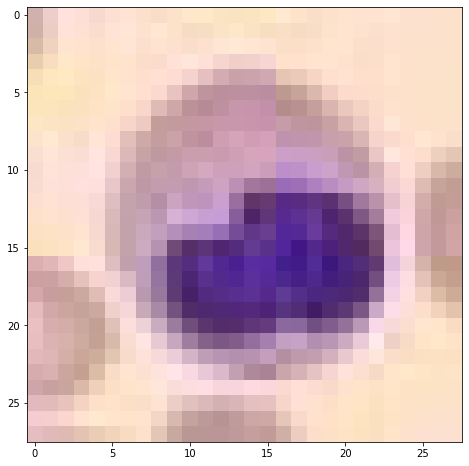

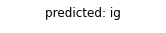

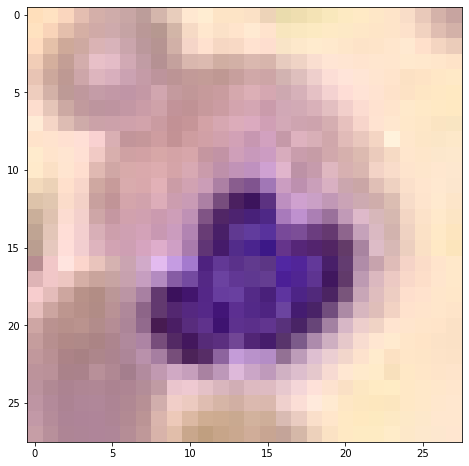

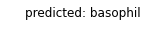

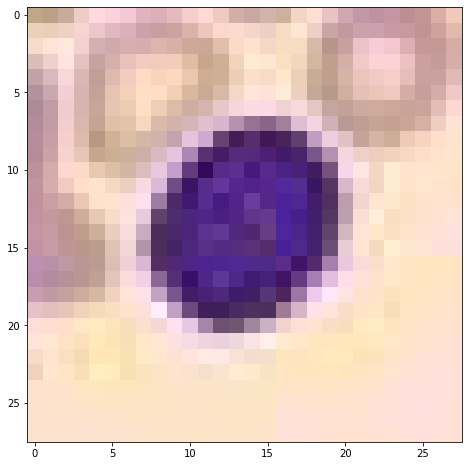

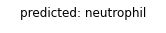

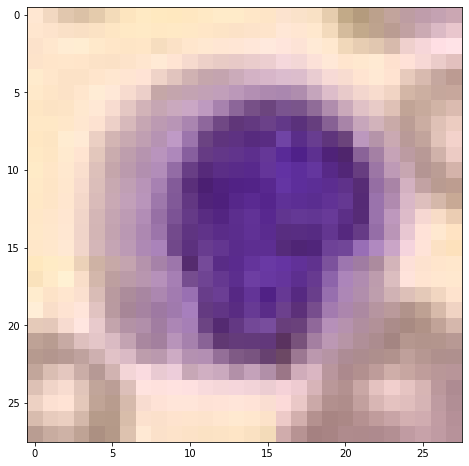

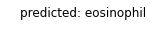

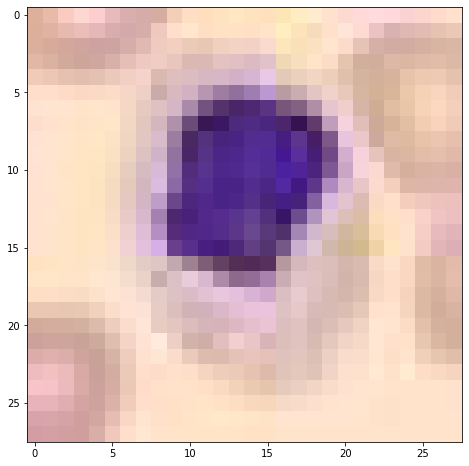

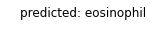

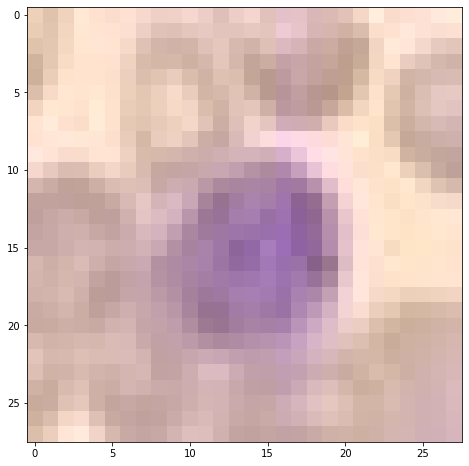

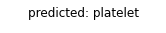

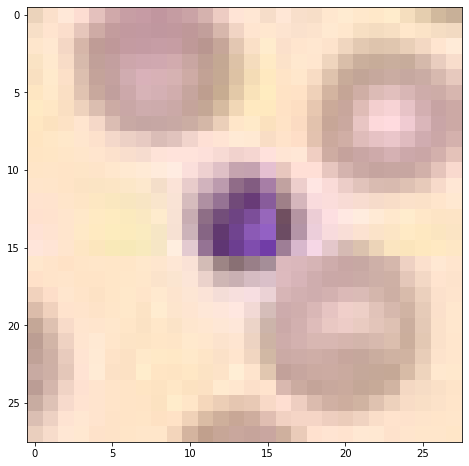

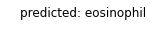

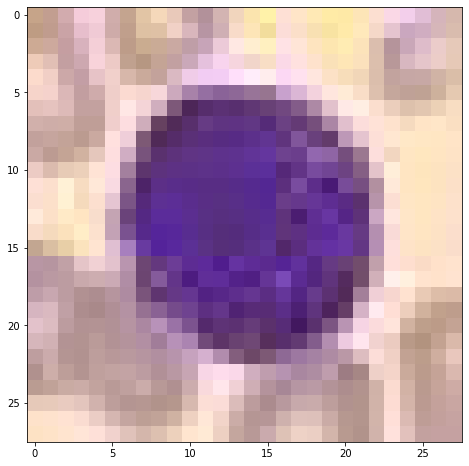

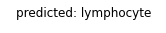

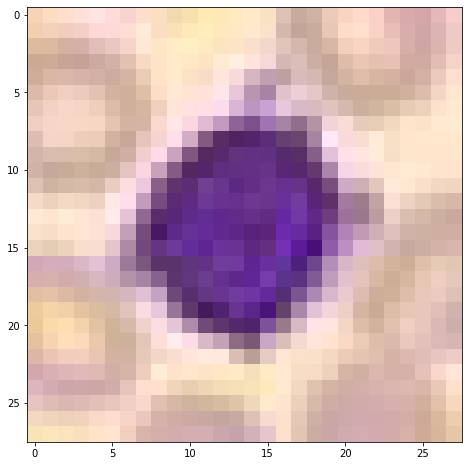

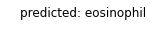

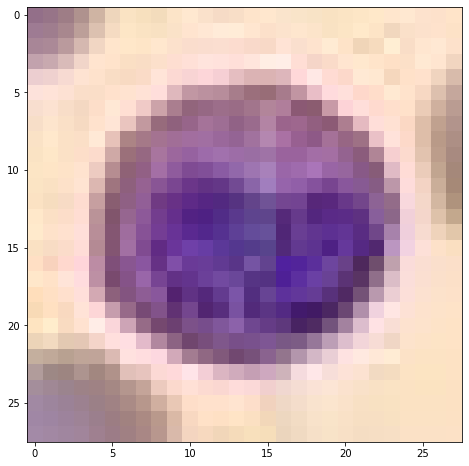

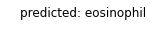

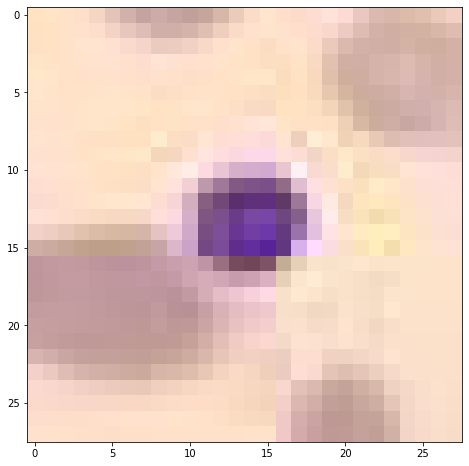

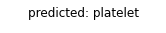

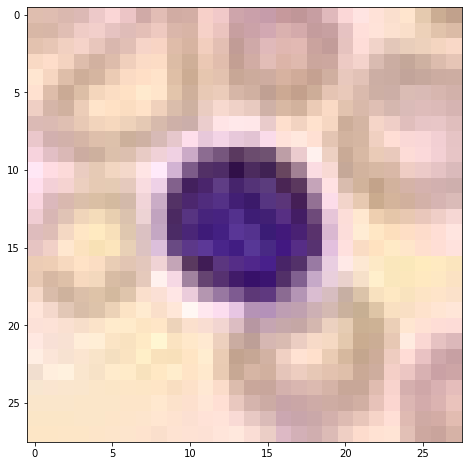

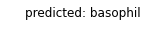

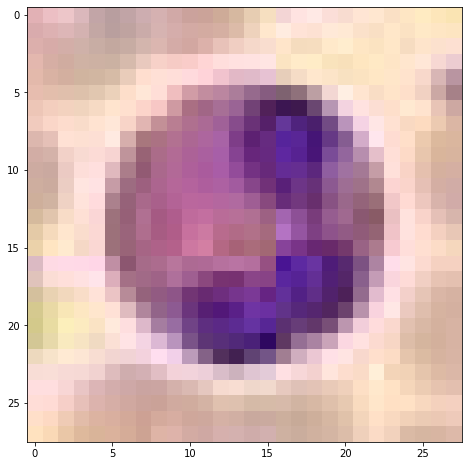

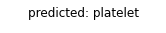

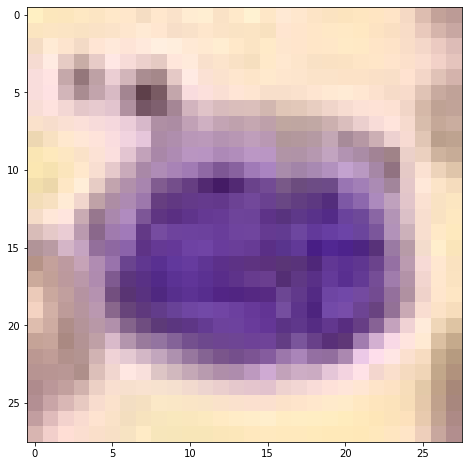

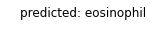

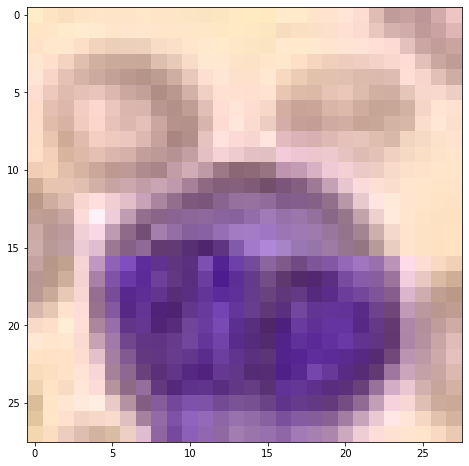

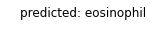

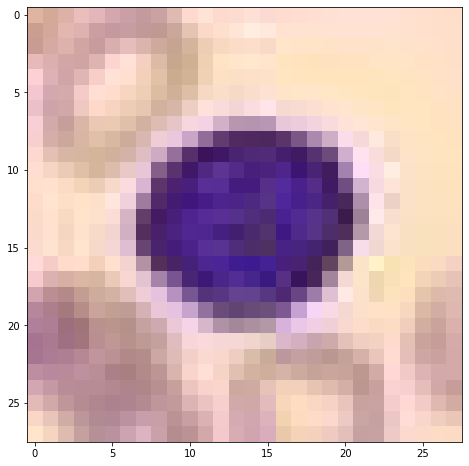

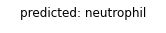

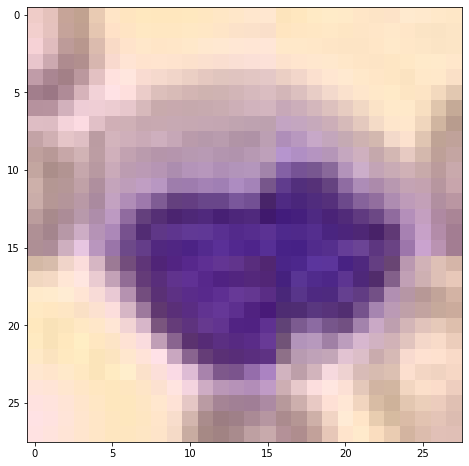

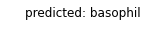

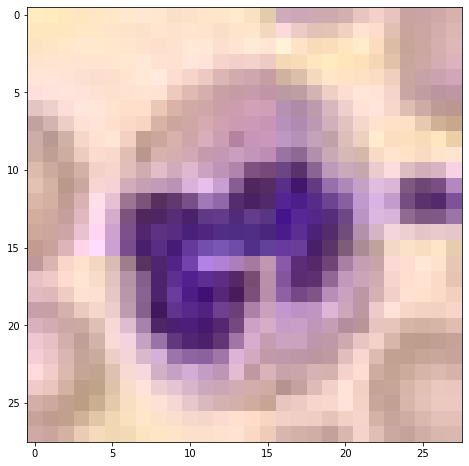

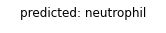

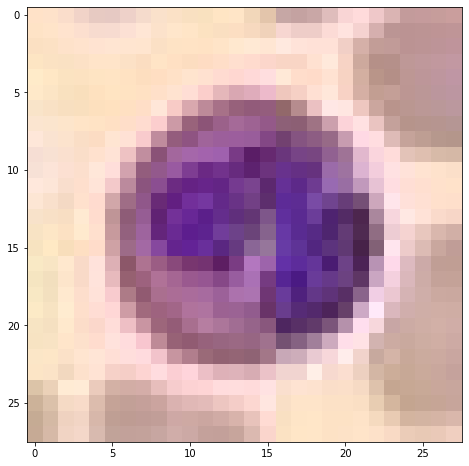

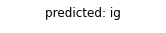

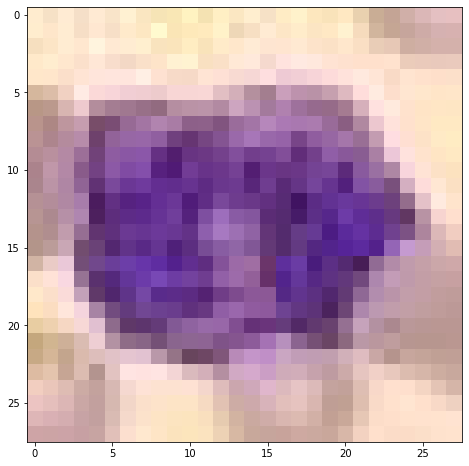

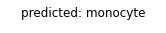

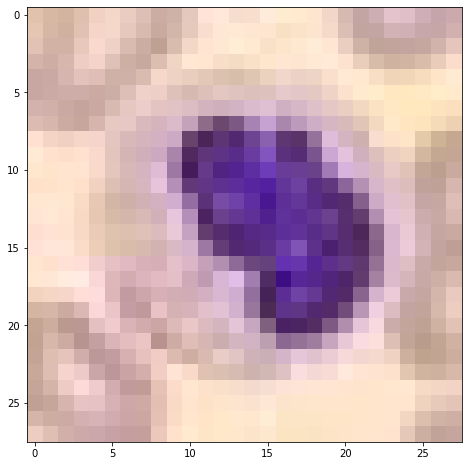

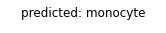

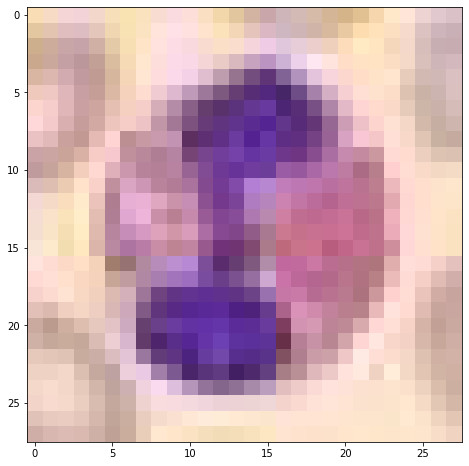

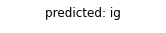

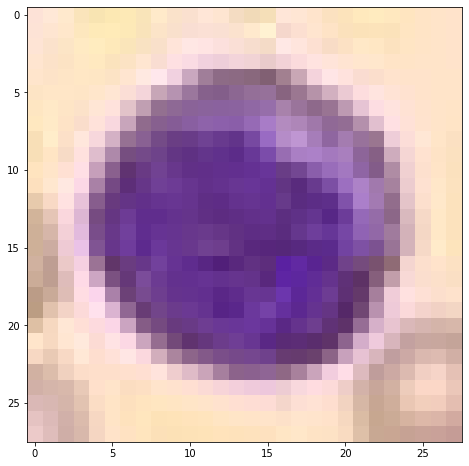

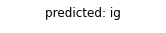

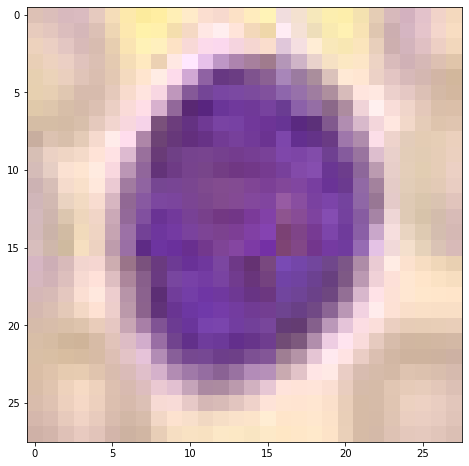

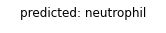

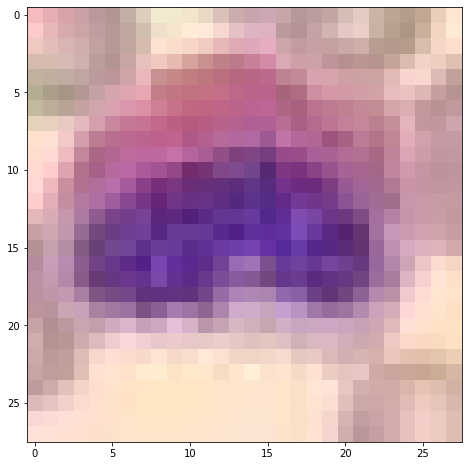

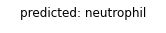

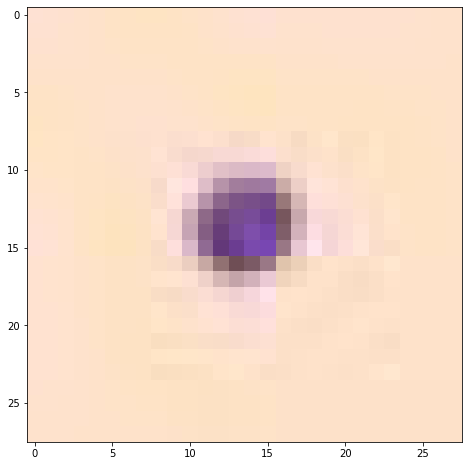

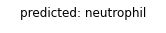

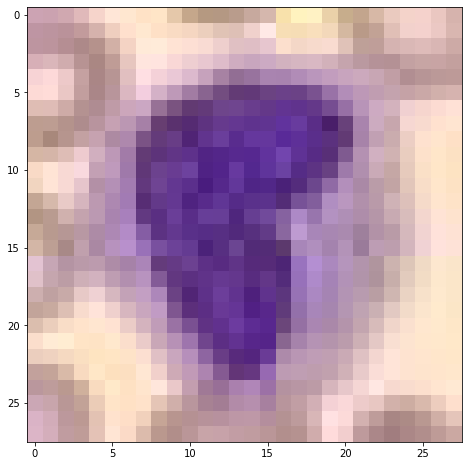

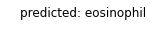

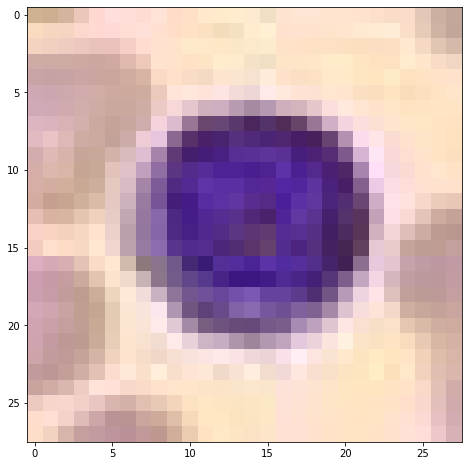

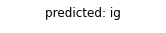

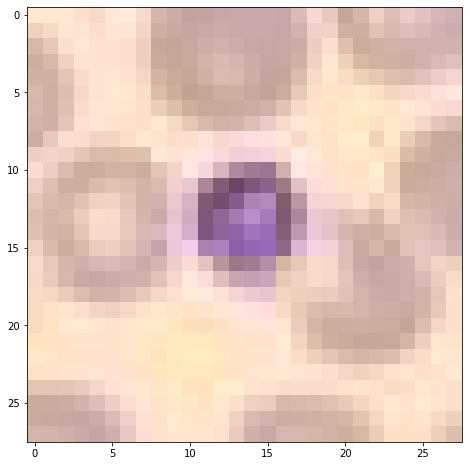

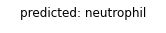

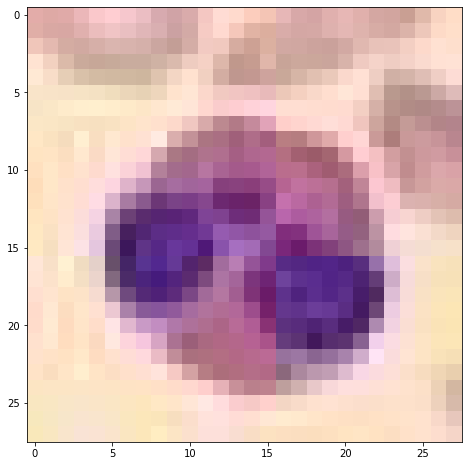

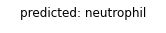

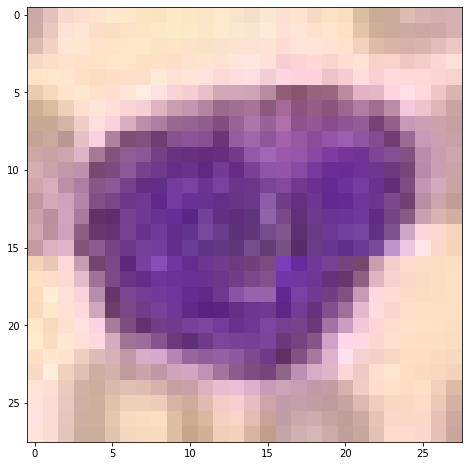

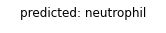

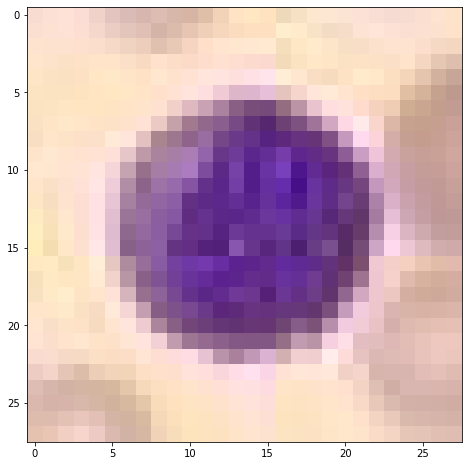

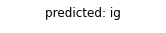

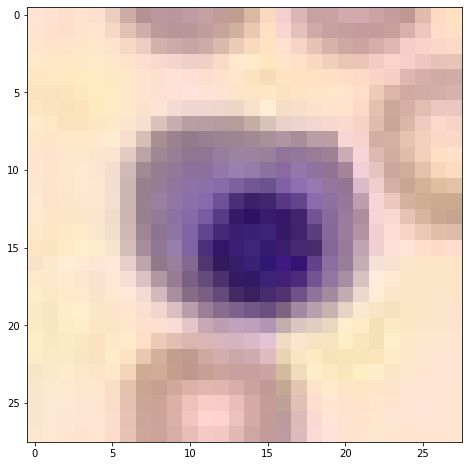

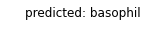

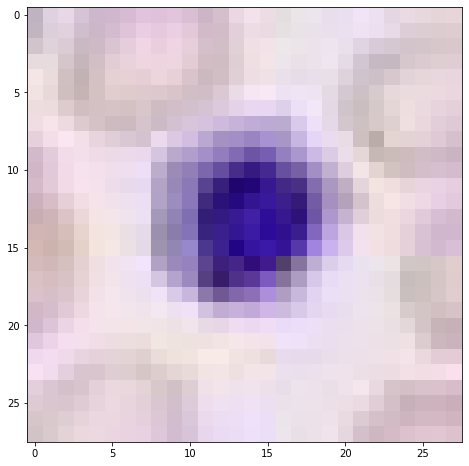

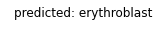

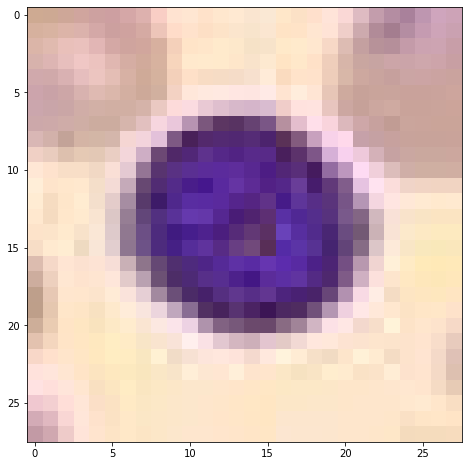

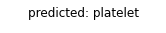

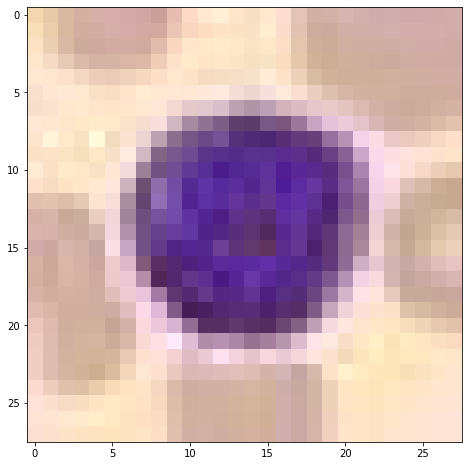

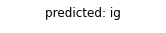

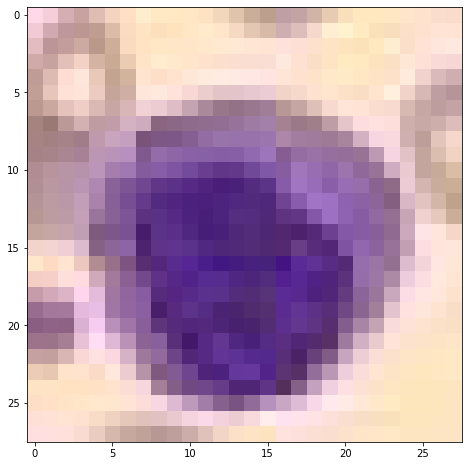

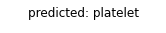

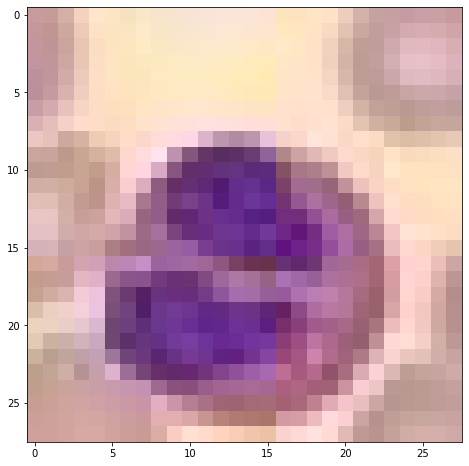

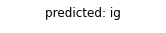

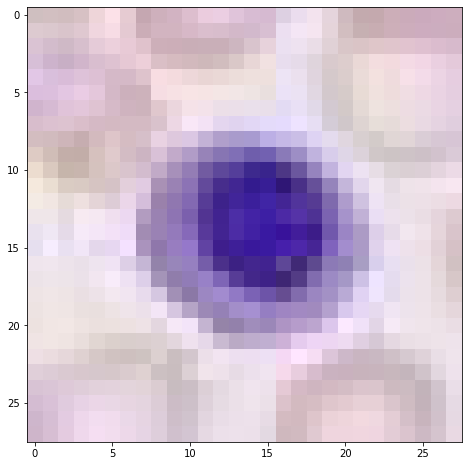

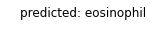

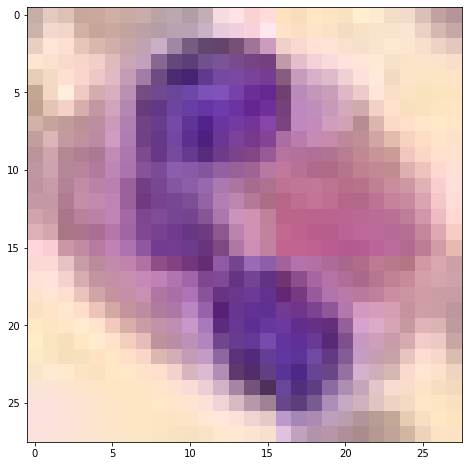

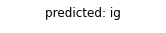

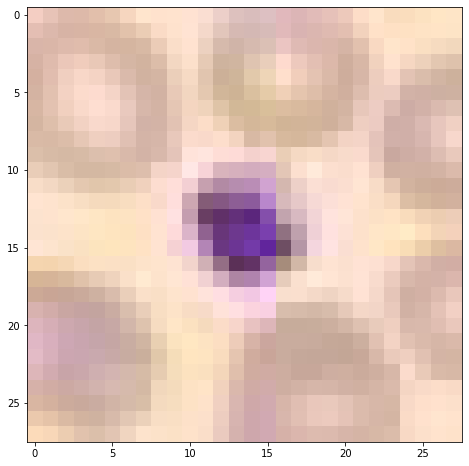

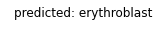

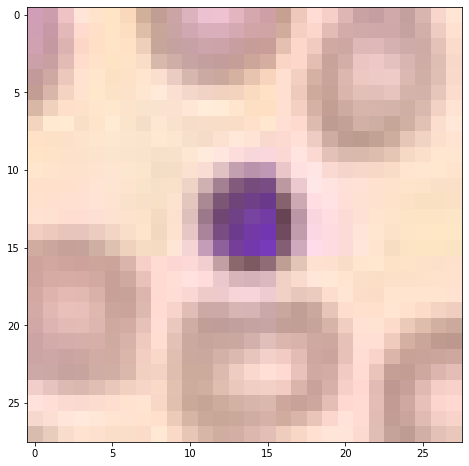

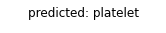

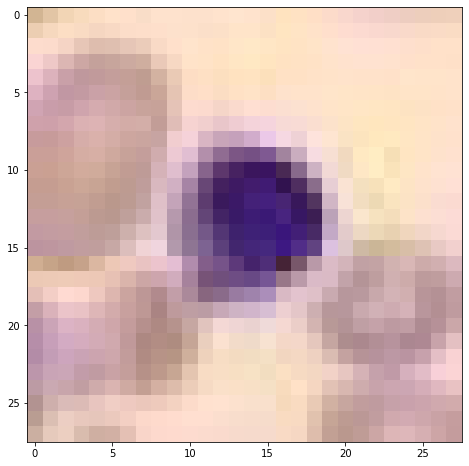

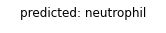

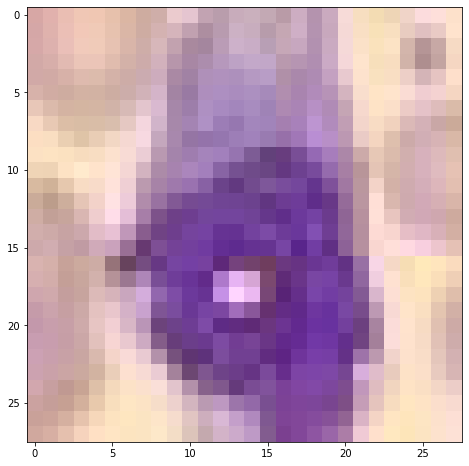

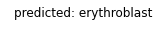

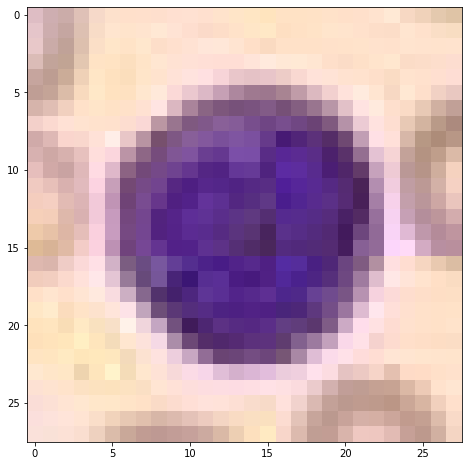

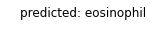

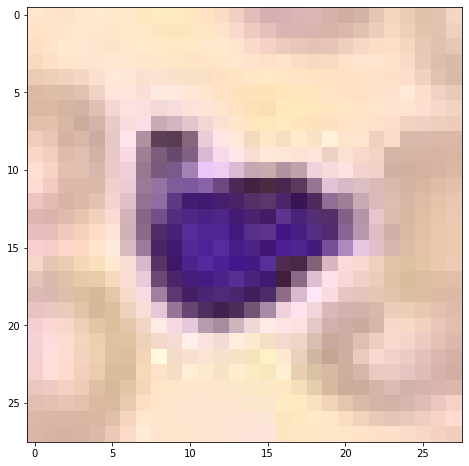

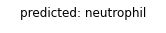

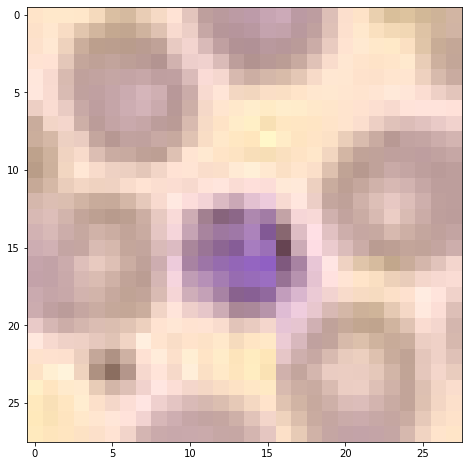

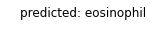

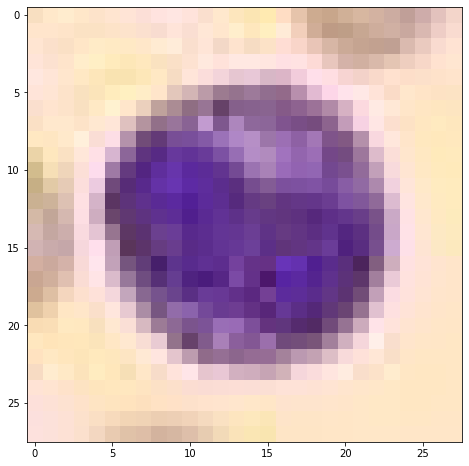

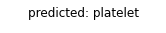

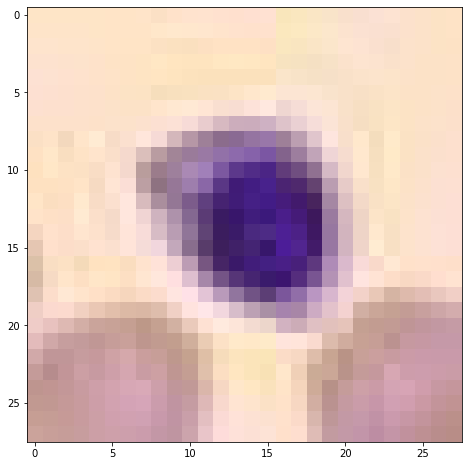

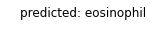

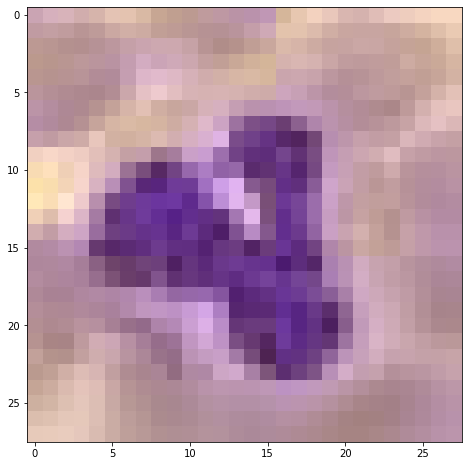

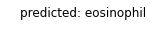

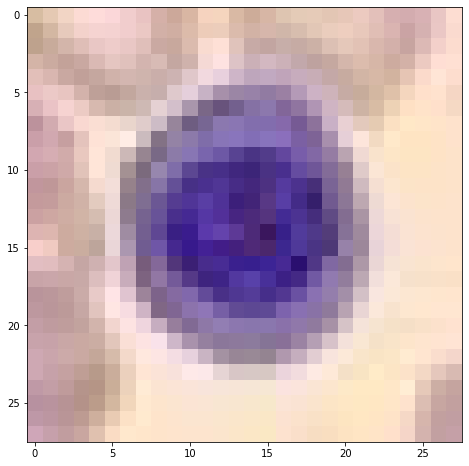

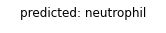

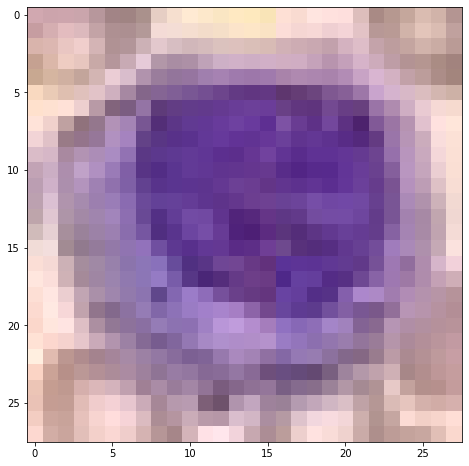

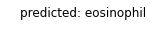

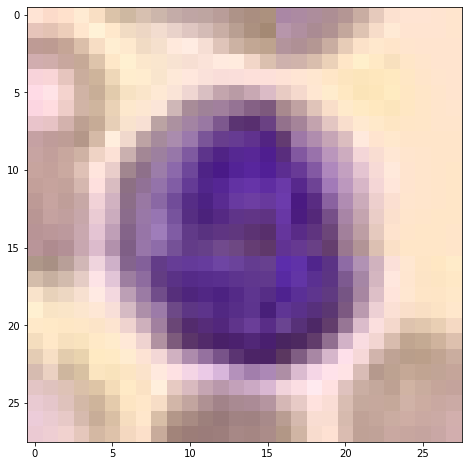

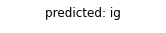

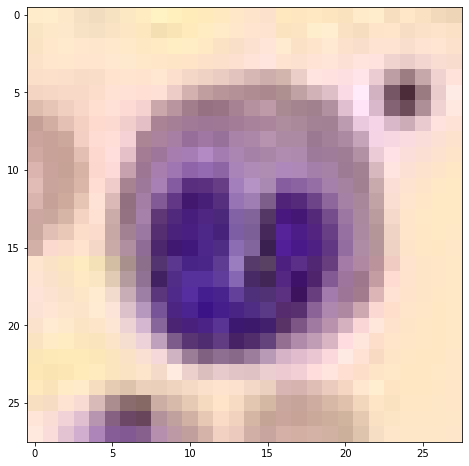

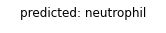

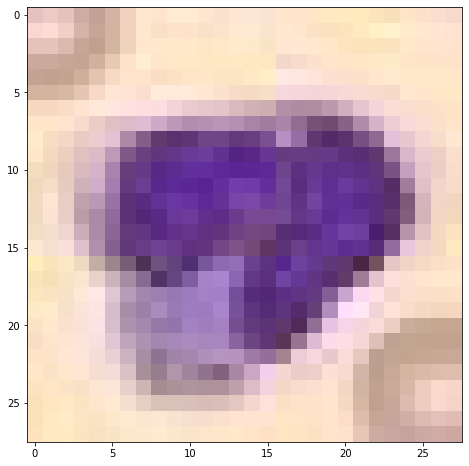

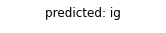

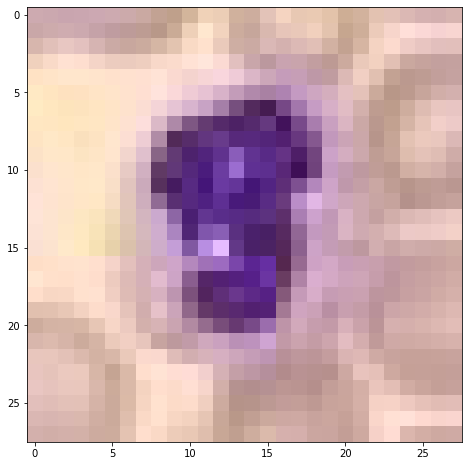

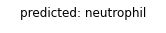

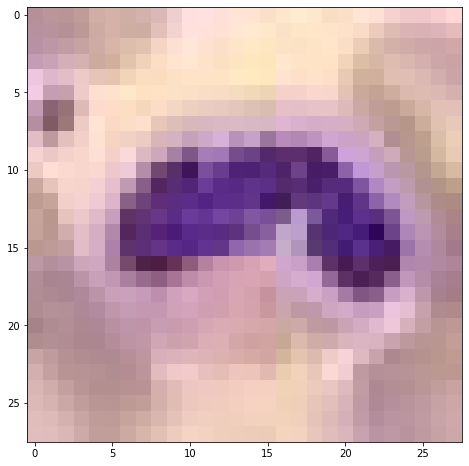

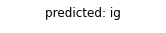

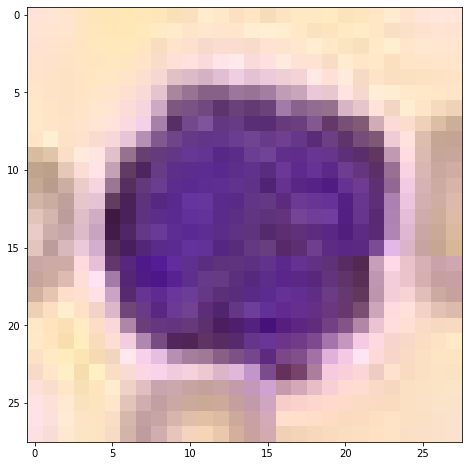

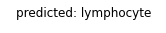

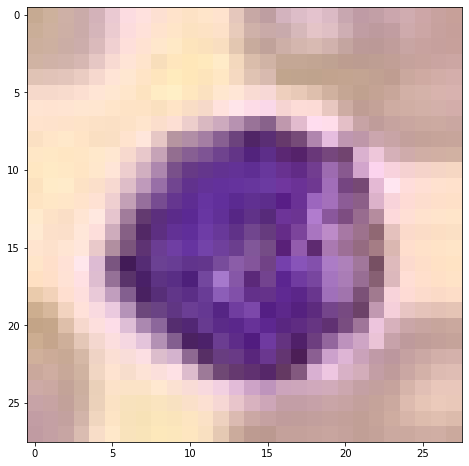

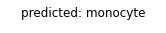

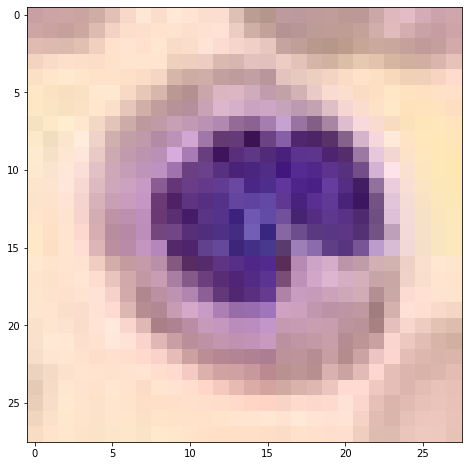

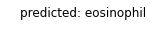

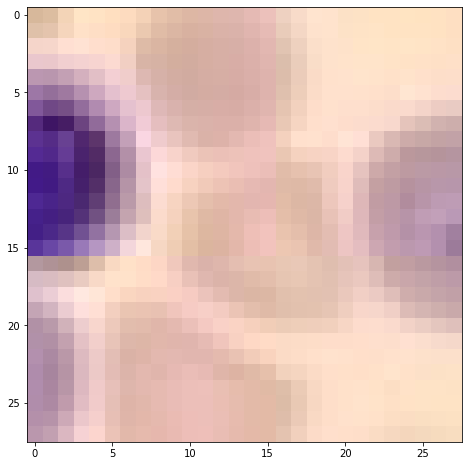

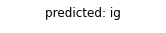

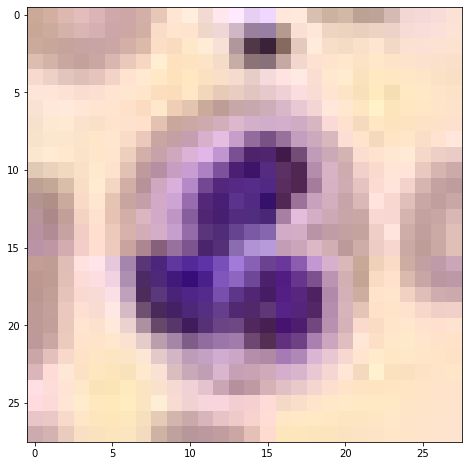

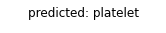

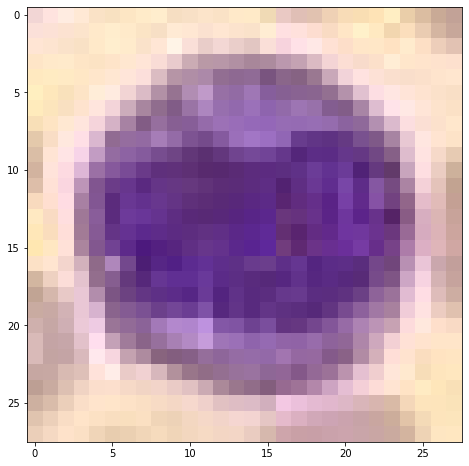

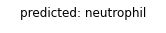

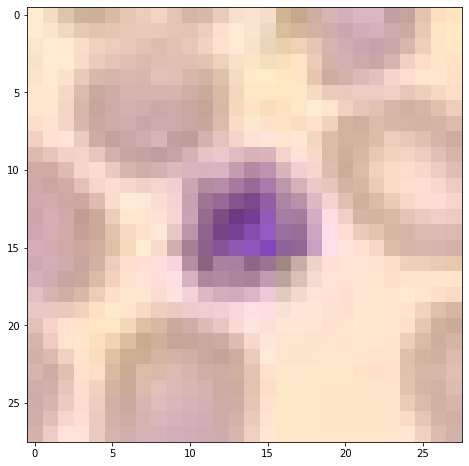

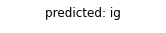

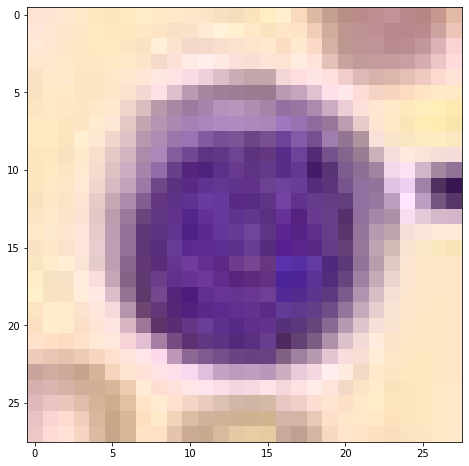

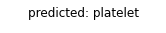

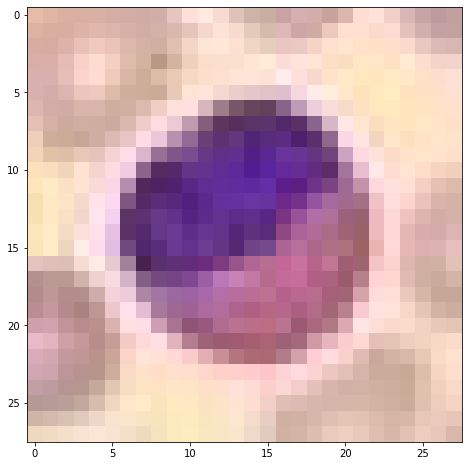

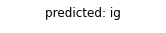

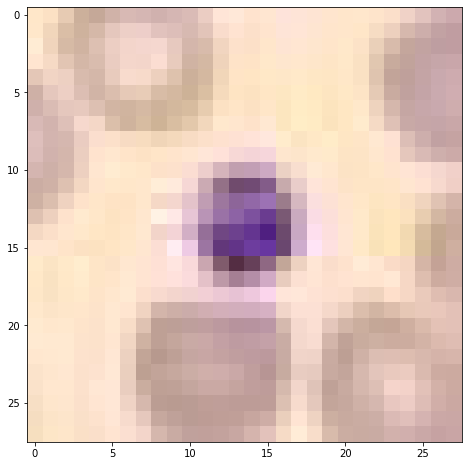

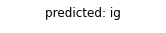

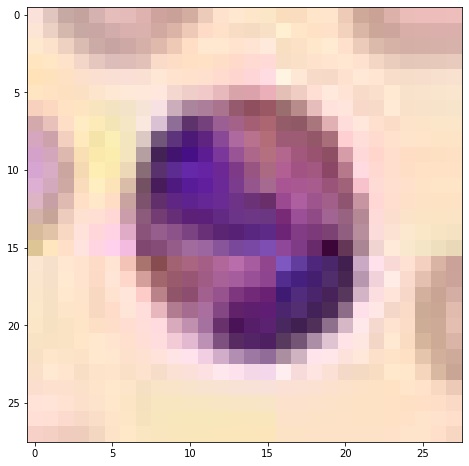

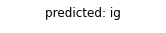

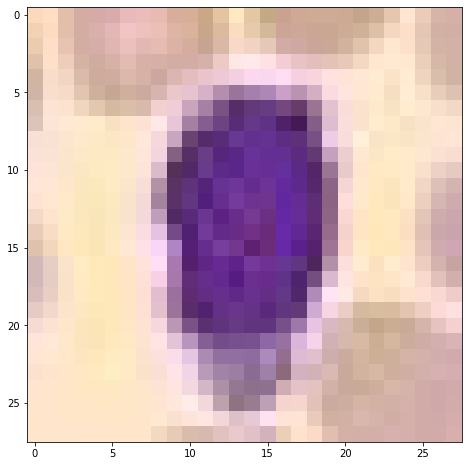

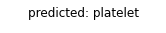

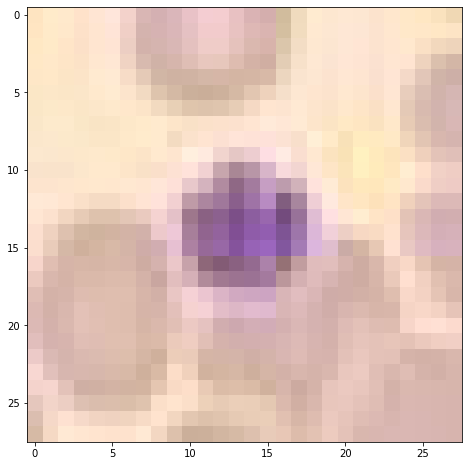

In [ ]:
visualize_model(model)